In [1]:
!which pip3

/home/mgross/anaconda3/envs/contrast-net/bin/pip3


In [2]:
! nvidia-smi

Wed Jan 28 06:50:32 2026       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 8000                Off | 00000000:17:00.0 Off |                  Off |
| 33%   33C    P8              23W / 260W |   2118MiB / 49152MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import IPython
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import pandas as pd
import pytorch_lightning
from monai.visualize import img2tensorboard
import torch
import time
import sklearn

from torch.utils.data import DataLoader

import monai
from monai.transforms import \
    Compose, LoadImaged, AddChanneld, Orientationd, \
    NormalizeIntensityd, ScaleIntensityRangePercentilesd, \
    SpatialPadd, Spacingd, Resized, \
    RandCropByPosNegLabeld, ToTensord,  \
    DataStatsd, AsDiscrete, KeepLargestConnectedComponent, RandFlipd
#LoadNiftid


from monai.data import list_data_collate
from monai.networks.layers import Norm

# from monai.metrics import compute_meandice
from monai.transforms import KeepLargestConnectedComponent

from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.utils import set_determinism
from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance


from monai.data import write_nifti
from tqdm.notebook import tqdm





monai.config.print_config()

MONAI version: 0.7.0
Numpy version: 1.20.3
Pytorch version: 1.8.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: bfa054b9c3064628a21f4c35bbe3132964e91f43

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.18.3
Pillow version: 8.3.1
Tensorboard version: 2.6.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.9.2
tqdm version: 4.62.3
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.3.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [4]:
print('CUDA available: ', torch.cuda.is_available())

n_gpus = torch.cuda.device_count()
for i in range(n_gpus):
    print('GPU %d: %s' % (i, torch.cuda.get_device_name(i)))


CUDA available:  True
GPU 0: Quadro RTX 8000


## Load the Data

In [5]:
INPUT_PATH = '../../ContrastNets.xlsx'
df = pd.read_excel(INPUT_PATH, index_col=False)

In [6]:
df_train, df_val, df_test = \
              np.split(df.sample(frac=1, random_state=50), 
                       [int(.7*len(df)), int(.85*len(df))])


df_train['DATA_SPLIT'] = 'Train'
df_val['DATA_SPLIT'] = 'Val'
df_test['DATA_SPLIT'] = 'Test'


df = pd.concat([df_train, df_val, df_test])

In [7]:
# Convert DF to dictionary
train_data_dict = df_train.to_dict('records')
val_data_dict = df_val.to_dict('records')
test_data_dict = df_test.to_dict('records')

## Setup Input Transformations

In [8]:
SPACING = (2.0,2.0,2.0)
#PATCH_SIZE = (96,96,16)
PATCH_SIZE = (64,64,32)




train_transforms = Compose([
    LoadImaged(keys=['PRE', 'DEL','SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['PRE', 'DEL', 'SEGM']),
    Orientationd(keys=['PRE', 'DEL', 'SEGM'], axcodes='RAS'),
    Spacingd(keys=['PRE', 'DEL', 'SEGM'], pixdim=SPACING, mode=('bilinear','bilinear', 'nearest'), padding_mode=('reflection', 'reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['PRE', 'DEL'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
    SpatialPadd(keys=['PRE', 'DEL', 'SEGM'], spatial_size=PATCH_SIZE, padding_mode=('reflection', 'reflection','reflection'), ),
#     DataStatsd(keys=['IMAGE','SEGM'], ARTfix=('train_image','train_segm')),
    # randomly crop out patch samples from big image based on pos / neg ratio
    # the image centers of negative samples must be in valid image area
    RandCropByPosNegLabeld(keys=['PRE', 'DEL', 'SEGM'], label_key='SEGM', spatial_size=PATCH_SIZE, pos=3, neg=1, num_samples=2),
    RandFlipd(keys=['PRE', 'DEL', 'SEGM'], prob=0.5, spatial_axis=0),
    ToTensord(keys=['PRE', 'DEL', 'SEGM'])
])

val_transforms = Compose([
    LoadImaged(keys=['PRE', 'DEL', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['PRE', 'DEL', 'SEGM']),
    Orientationd(keys=['PRE', 'DEL', 'SEGM'], axcodes='RAS'),
    Spacingd(keys=['PRE', 'DEL', 'SEGM'], pixdim=SPACING, mode=('bilinear','bilinear', 'nearest'), padding_mode=('reflection', 'reflection','reflection')),
    #Resized(keys=['PRE', 'DEL', 'DEL', 'LIVER_SEGM'], spatial_size=PATCH_SIZE),
    ScaleIntensityRangePercentilesd(keys=['PRE', 'DEL'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),    
#     DataStatsd(keys=['IMAGE','SEGM'], ARTfix=('val_image','val_segm')),
    ToTensord(keys=['PRE', 'DEL', 'SEGM'])
])

test_transforms = Compose([
    LoadImaged(keys=['PRE', 'DEL', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['PRE', 'DEL', 'SEGM']),
    Orientationd(keys=['PRE', 'DEL', 'SEGM'], axcodes='RAS'),
    Spacingd(keys=['PRE', 'DEL', 'SEGM'], pixdim=SPACING, mode=('bilinear','bilinear', 'nearest'), padding_mode=('reflection','reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['PRE', 'DEL'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
#     DataStatsd(keys=['IMAGE','SEGM'], ARTfix=('val_image','val_segm')),
    ToTensord(keys=['PRE', 'DEL', 'SEGM'])
])


inference_transforms = Compose([
     LoadImaged(keys=['PRE', 'DEL'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['PRE', 'DEL']),
    Orientationd(keys=['PRE', 'DEL'], axcodes='RAS'),
    Spacingd(keys=['PRE', 'DEL'], pixdim=SPACING, mode=('bilinear','bilinear'), padding_mode=('reflection', 'reflection')),
    ScaleIntensityRangePercentilesd(keys=['PRE', 'DEL', 'DEL'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
#     DataStatsd(keys=['IMAGE','SEGM'], ARTfix=('val_image','val_segm')),
    ToTensord(keys=['PRE', 'DEL'])
])



## Create a Persistent Data Cache for Training and Validation Data

In [9]:
CACHE_PATH = '/tensor5/data1/mgross/Liver/studies/Contrast-Nets/PRE-DEL-Net/monai_cache'


In [10]:
train_ds = monai.data.PersistentDataset(
    data=train_data_dict, transform=train_transforms, cache_dir=CACHE_PATH
)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4, collate_fn=list_data_collate)

In [11]:
val_ds = monai.data.PersistentDataset(
    data=val_data_dict, transform=val_transforms, cache_dir=CACHE_PATH
)

val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, collate_fn=list_data_collate)

In [12]:
test_ds = monai.data.Dataset(
    data=test_data_dict, transform=test_transforms)

test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)

## Check Input Data

torch.Size([20, 1, 64, 64, 32])
torch.Size([20, 1, 64, 64, 32])
PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.4760512709617615
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.6135168075561523


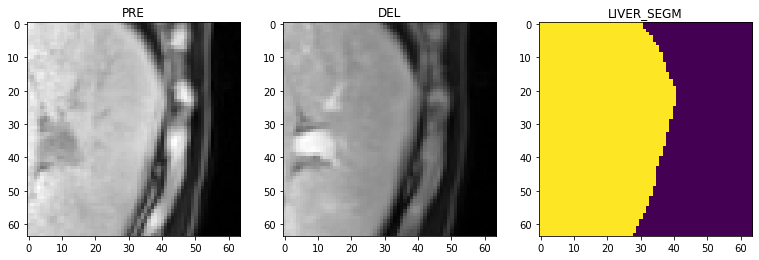

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.7661097645759583
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 1.0665483474731445


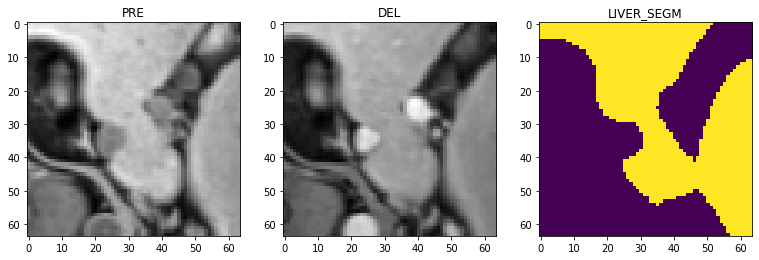

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.6914584040641785
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.9903876185417175


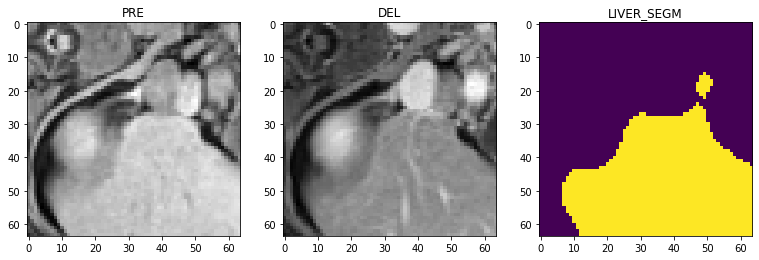

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.31333523988723755
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.42014992237091064


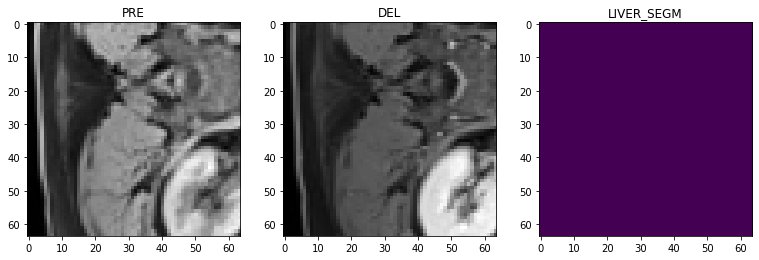

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.8562739491462708
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 1.0264344215393066


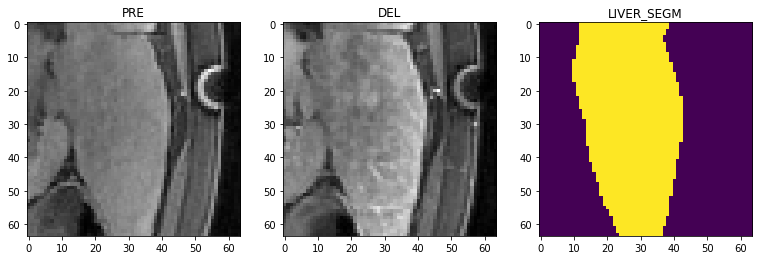

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.26369890570640564
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.4344303011894226


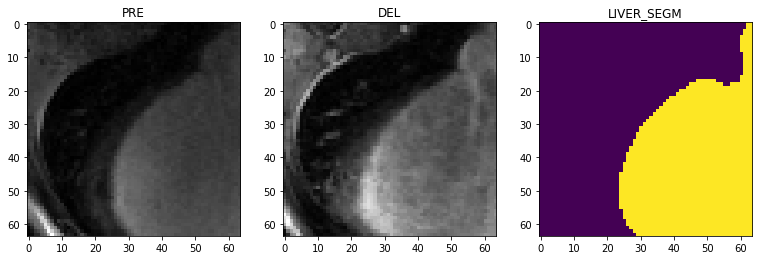

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.3917992413043976
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.5130407810211182


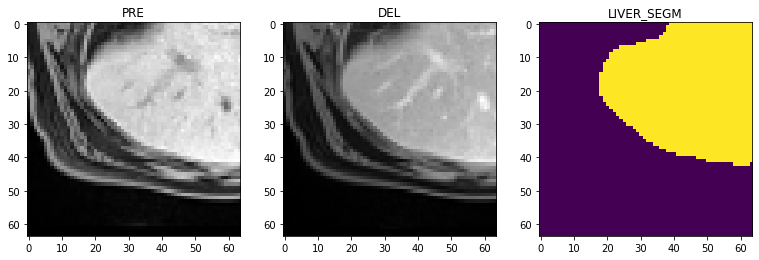

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.6504961252212524
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.8097427487373352


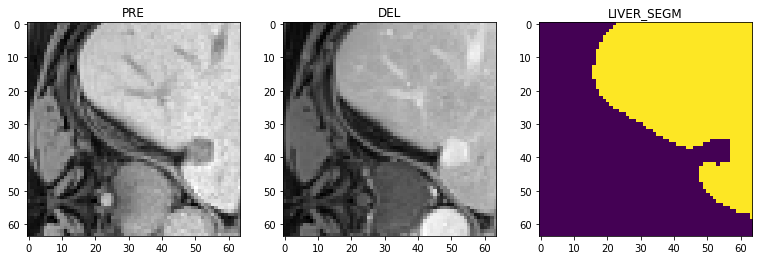

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.5395554900169373
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.5133695006370544


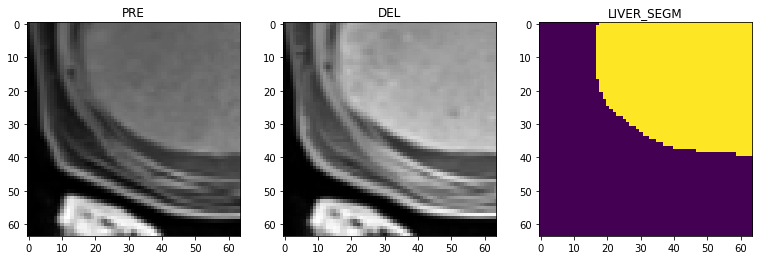

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.791365385055542
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.752056360244751


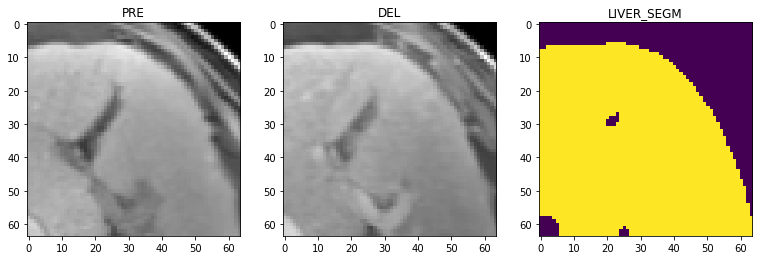

In [13]:
check_ds = monai.data.Dataset(data=train_data_dict[:10], transform=train_transforms)
#check_ds = monai.data.Dataset(data=val_data_dict[10:11], transform=val_transforms)
#check_ds = monai.data.Dataset(data=test_data_dict[:1], transform=test_transforms)

check_loader = DataLoader(check_ds, batch_size=10, num_workers=0, collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data['PRE'].shape)
print(check_data['DEL'].shape)


num_display = 10
if check_data['PRE'].shape[0] < num_display:
    num_display = check_data['DEL'].shape[0]

for i in range(num_display):
    PRE, DEL, liver_label = (check_data['PRE'][i][0],check_data['DEL'][i][0], check_data['SEGM'][i][0])


    
    print('PRE shape: {}, label shape: {}'.format(PRE.shape, liver_label.shape))
    print('PRE mean: {}'.format(np.mean(PRE.numpy())))
    
    
    print('DEL shape: {}, label shape: {}'.format(DEL.shape, liver_label.shape))
    print('DEL mean: {}'.format(np.mean(DEL.numpy())))
    
    slice_num = PRE.shape[2]//2
    
    plt.figure('check', (13, 15))

    plt.subplot(1, 3, 1)
    plt.title('PRE')
    plt.imshow(PRE[:,:,slice_num], cmap='gray')

 
    
    plt.subplot(1, 3, 2)
    plt.title('DEL')
    plt.imshow(DEL[:,:,slice_num], cmap='gray')

    plt.subplot(1, 3 ,3)
    plt.title('LIVER_SEGM')
    plt.imshow(liver_label[:,:,slice_num])
    
    plt.show()



    


## Create Segmentation Model (U-net)

In [14]:
class MRILiverSegmentation(pytorch_lightning.LightningModule):

    def __init__(self, dropout_rate = 0.0):
        super().__init__()
        
        self._model = monai.networks.nets.UNet(
            dimensions=3, 
            in_channels=2, 
            out_channels=2, 
            channels=(16, 32, 64, 128),
            strides=(2, 2, 2), 
            num_res_units=2, 
            norm=Norm.BATCH,
            dropout = dropout_rate,
        )

    
        self.loss_function = monai.losses.DiceLoss(include_background=False, to_onehot_y=True, softmax=True)
        self.one_hot_transform = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
        self.val_metric = DiceMetric(include_background=False)

        self.best_val_dice = None
        self.best_val_epoch = None
        
        
    def forward(self, x):
        return self._model(x)

    
    def prepare_data(self):
        # set deterministic training for reproducibility
        set_determinism(seed=0)
    
    
    def training_step(self, batch, batch_idx):

        pre_images =  batch["PRE"]
        del_images =  batch["DEL"]
        
        
        images = torch.cat((pre_images, del_images) ,dim=1)
        labels = batch["SEGM"]

        
        
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        return {"loss": loss}
    
    
    def training_epoch_end(self, outputs):
        # Only add the graph at the first epoch
        if self.current_epoch==1:
            #sample_input = torch.rand((1,1,96,96,16))
            sample_input = torch.rand((1,2,64,64,32))
            self.logger.experiment.add_graph(
                MRILiverSegmentation(), 
                [sample_input])
        
        # Calculate the average loss
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Train/Loss', avg_loss, self.current_epoch)
    
    

    def validation_step(self, batch, batch_idx):
        
        
        pre_images =  batch["PRE"]
        del_images =  batch["DEL"]
        

        
        images = torch.cat((pre_images, del_images) ,dim=1)
        labels = batch["SEGM"]
        
        
        #images = batch["IMAGE"]
        #labels = batch["SEGM"]

        #roi_size = (256, 256, 48)
        roi_size = (224, 224, 128)
        sw_batch_size = 4
        outputs = sliding_window_inference(images, roi_size, sw_batch_size, self.forward)

        loss = self.loss_function(outputs, labels)

#         one_hot = monai.networks.utils.one_hot(labels, num_classes=3)
        argmax = torch.argmax(outputs, dim=1, keepdim=True)
        val_dice = self.val_metric(
            self.one_hot_transform(argmax), 
            self.one_hot_transform(labels)
        )
                
        if batch_idx<1:
            img2tensorboard.plot_2d_or_3d_image(data=images, 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Validation/Input')
            img2tensorboard.plot_2d_or_3d_image(data=argmax, 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Validation/Output')

        return {"val_loss": loss, "val_dice": val_dice}
    
    def validation_epoch_end(self, outputs):
        # Calculate the average loss
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_dice = torch.stack([x['val_dice'][0] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Val/Loss', avg_loss, self.current_epoch)
        self.logger.experiment.add_scalar('Val/Dice', avg_dice, self.current_epoch)
        
        self.log('val_loss', avg_loss)
        self.log('val_dice', avg_dice)

    
    def configure_optimizers(self):
        return torch.optim.Adam(self._model.parameters(), lr=1e-4)
    
    

In [15]:
from torchinfo import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MRILiverSegmentation()
#summary(model.to(device), [1,1,96,96,16])
summary(model.to(device), [1,2,64,64,32])

Layer (type:depth-idx)                                                           Output Shape              Param #
MRILiverSegmentation                                                             --                        --
├─UNet: 1-1                                                                      [1, 2, 64, 64, 32]        --
│    └─Sequential: 2-1                                                           [1, 2, 64, 64, 32]        --
│    │    └─ResidualUnit: 3-1                                                    [1, 16, 32, 32, 16]       8,754
│    │    └─SkipConnection: 3-2                                                  [1, 32, 32, 32, 16]       1,178,186
│    │    └─Sequential: 3-3                                                      [1, 2, 64, 64, 32]        1,845
Total params: 1,188,785
Trainable params: 1,188,785
Non-trainable params: 0
Total mult-adds (G): 1.69
Input size (MB): 1.05
Forward/backward pass size (MB): 45.22
Params size (MB): 4.76
Estimated Total Size (MB):

## Model Training

In [16]:
MODEL_ROOT_PATH = r'/tensor5/data1/mgross/Liver/studies/Contrast-Nets/PRE-DEL-Net/'


In [17]:
# initialise the LightningModule
model = MRILiverSegmentation(dropout_rate=0.3)

# set up loggers and checkpoints
tb_logger = pytorch_lightning.loggers.TensorBoardLogger(
    save_dir=os.path.join(MODEL_ROOT_PATH,'saved_model','logs')
)

lr_monitor = pytorch_lightning.callbacks.LearningRateMonitor(logging_interval='epoch')

checkpoint_callback = pytorch_lightning.callbacks.ModelCheckpoint(
    dirpath=os.path.join(MODEL_ROOT_PATH,'saved_model'),
    filename="MRILiverSegmentation-{epoch:04d}-{val_loss:.2f}",
    monitor='val_loss',
    save_last=True,
    save_on_train_epoch_end=True,
    save_top_k=2,
    mode='min'
)

# check for last checkpoint
resume_checkpoint = None
if os.path.exists(os.path.join(MODEL_ROOT_PATH,'saved_model','last.ckpt')):
    resume_checkpoint = os.path.join(MODEL_ROOT_PATH,'saved_model','last.ckpt')

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    gpus=[0],
    max_epochs=2000,
    logger=tb_logger,
    callbacks=[lr_monitor,checkpoint_callback],
    num_sanity_val_steps=1,
    check_val_every_n_epoch=20,
    resume_from_checkpoint=resume_checkpoint
)

# train
trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:45: LightningDeprecationWarning: Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and will be removed in v1.7. Please pass `Trainer.fit(ckpt_path=)` directly instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:730: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1893: LightningDeprecationWarning: `trainer.resume_from_checkpoint` is deprecated in v1.5 and will be removed in v1.7. Specify the fit ch

Validation sanity check: 0it [00:00, ?it/s]

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:56: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 7. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


## Model Testing

In [18]:
model_path = os.path.join(MODEL_ROOT_PATH,'saved_model','MRILiverSegmentation-epoch=0919-val_loss=0.06.ckpt')

In [19]:
model = MRILiverSegmentation.load_from_checkpoint(model_path)
# model.load_from_checkpoint(model_path)
model.eval()
device = torch.device("cuda:0")
model.to(device)

MRILiverSegmentation(
  (_model): UNet(
    (model): Sequential(
      (0): ResidualUnit(
        (conv): Sequential(
          (unit0): Convolution(
            (conv): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
            (adn): ADN(
              (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
          (unit1): Convolution(
            (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (adn): ADN(
              (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
        )
        (residual): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      )
      (1): SkipConnection(
        

In [20]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import torch
import time


from monai.transforms import KeepLargestConnectedComponent
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance


from monai.data import write_nifti
from tqdm.notebook import tqdm
from monai.data import decollate_batch




def compute_evaluation_metrics(y_pred, y, keep=False):
    
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    hd = monai.metrics.HausdorffDistanceMetric(include_background=False, reduction="mean", percentile=95, get_not_nans=False)
    mad = monai.metrics.SurfaceDistanceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep_largest = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    dice_list = list()
    hd_list = list()
    mad_list = list()
    for y_pred_i, y_i in decollate_batch((y_pred, y)):
        print(y_pred_i.shape)
        print(y_i.shape)
        if keep:
            #dice(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            #hd(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            #mad(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            y_pred_i_proc=one_hot(keep_largest(argmax(y_pred_i)))
        else:
                
            # Calculate Dice on the raw output
            #dice(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            #hd(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            #mad(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            y_pred_i_proc = one_hot(argmax(y_pred_i))
        y_pred_i_proc = monai.transforms.AddChannel()(y_pred_i_proc)
        y_i_proc = monai.transforms.AddChannel()(one_hot(y_i))
        print(y_pred_i_proc.shape)
            
        #dice(y_pred=y_pred_i_proc, y=one_hot(y_i))
        #hd(y_pred=y_pred_i_proc, y=one_hot(y_i))
        #mad(y_pred=y_pred_i_proc, y=one_hot(y_i))
            
        dice(y_pred=y_pred_i_proc, y=y_i_proc)
        hd(y_pred=y_pred_i_proc, y=y_i_proc)
        mad(y_pred=y_pred_i_proc, y=y_i_proc)
        
        dice_value = dice.aggregate().item()
        hd_value = hd.aggregate().item()
        mad_value = mad.aggregate().item()
        
        print(dice_value)
        print(hd_value)
        print(mad_value)
        
        dice_list.append(dice_value)
        hd_list.append(hd_value)
        mad_list.append(mad_value)
              
    return dice_list, hd_list, mad_list


def run_inference_and_evaluate(model, data_loader, plot_images=False, max_eval=None, 
                               save_output=False,roi_size=(224,224,128), sw_batch_size=4, output_path=None):
    
    """Inference and evaluation function for Liver segmentation.
    
    """   
    
    df_eval = pd.DataFrame()
    
    acc_ids = list()
    input_paths = list()
    output_paths = list()
    
    original_dice_results = list()
    postprocess_dice_results = list()

    original_hd_results = list()
    postprocess_hd_results = list()

    original_mad_results = list()
    postprocess_mad_results = list()
    
    inference_times = list()
    


    
    # Use MONAI one_hot transform
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    with torch.no_grad():
        for i, test_data in tqdm(enumerate(data_loader)):
        # Early stopping
            if max_eval is not None:
                if i>=max_eval:
                    break

            #print(test_data['ACCESSION_ID'][0])
            #for val in test_data['ACCESSION_ID'][0]:
            #    acc_ids.append(val)

    
            pre_images =  test_data["PRE"].to(device)
            del_images =  test_data["DEL"].to(device)
            
            x = torch.cat((pre_images, del_images) ,dim=1)
            y = test_data['SEGM'].cpu()




            start_time = time.time()
            y_pred = sliding_window_inference(x, roi_size, sw_batch_size, model)
            stop_time = time.time()

            inference_time = stop_time-start_time
            inference_times.append(inference_time)

            x = x.detach().cpu()
            y_pred = y_pred.detach().cpu()
            #print(y_pred.shape)

            #argmax = torch.argmax(y_pred, dim=1, keepdim=True)
            #argmax = argmax.detach().cpu()

            #y_onehot = one_hot(y)
            #y_pred_onehot = one_hot(argmax)

            # Evaluate segmentation metrics
            eval_list = list()
            # Update to MONAI 0.7+
            dice_values, hd_values, mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y
            )

            for val in dice_values:
                original_dice_results.append(val)
            for val in hd_values:
                original_hd_results.append(val)
            for val in mad_values:
                original_mad_results.append(val)



            post_dice_values, post_hd_values, post_mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y, keep=True
            )        #dice_list = list()
            #post_dice_list = list()

            for val in post_dice_values:
                postprocess_dice_results.append(val)
            for val in post_hd_values:
                postprocess_hd_results.append(val)
            for val in post_mad_values:
                postprocess_mad_results.append(val)





            print(y_pred.shape)
            print(argmax(y_pred[0,...]).shape)


            if plot_images:
                pre_img = pre_images.detach().cpu()
                del_img = del_images.detach().cpu()
                


                slice_num = x.shape[-1]//2

                plt.figure('check', (9, 3))
                plt.subplot(1, 4, 1)
                plt.title('PRE')
                plt.imshow(pre_img[0,0,:,:,slice_num], cmap='gray')

                plt.subplot(1, 4, 1)
                plt.title('DEL')
                plt.imshow(del_img[0,0,:,:,slice_num], cmap='gray')

            
                plt.subplot(1, 4, 3)
                plt.title('SEGM')
                plt.imshow(y[0,0,:,:,slice_num])

                plt.subplot(1, 4, 4)
                plt.title('PRED')
                #plt.imshow(argmax(y_pred[0,...])[0,:,:,slice_num])
                plt.imshow(keep(argmax(y_pred[0,...]))[0,:,:,slice_num])
                plt.show()


            # Write data out
            if save_output:
                # Get the image affine matrix
                current_affine = test_data['PRE_meta_dict']['affine'][0].numpy()
                original_affine = test_data['PRE_meta_dict']['original_affine'][0].numpy()
                original_spatial_shape = test_data['PRE_meta_dict']['spatial_shape'][0].numpy()

                input_file_name = test_data['PRE_meta_dict']['filename_or_obj'][0]
                output_file_name = os.path.split(input_file_name)[1]
                output_root_name = output_file_name[:-len('.nii.gz')]
                output_path_final = os.path.join(output_path,'{}_segm.nii.gz'.format(output_root_name))
                print('Saving segmentation results: {}'.format(output_path_final))
                
                output_paths.append(output_path_final)
                
                #output_segm = argmax.cpu()[0, 0,...].numpy()
                output_segm = keep(argmax(y_pred[0,...])).cpu()[0,...].numpy()
                write_nifti(output_segm, output_path_final,
                            mode='nearest',
                            affine=current_affine, 
                            target_affine=original_affine,
                            output_spatial_shape=original_spatial_shape, 
                            dtype=np.float32
                           )

    
    #df_eval['ACCESSION_ID'] = acc_ids
    #df_eval['PV'] = input_paths
    df_eval['DICE'] = original_dice_results
    print(original_dice_results)
    df_eval['POST_DICE'] = postprocess_dice_results
    df_eval['HD95'] = original_hd_results
    df_eval['POST_HD95'] = postprocess_hd_results
    #df_eval['MAD'] = original_mad_results
    #df_eval['POST_MAD'] = postprocess_mad_results
    df_eval['InferenceTime'] = inference_times
    if output_path is not None:
        df_eval['AUTOMATED-LIVER-SEGM'] = output_paths    
    return df_eval


In [21]:
OUTPUT_PATH = r'/tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL'

0it [00:00, ?it/s]

torch.Size([2, 201, 151, 108])
torch.Size([1, 201, 151, 108])
torch.Size([1, 2, 201, 151, 108])
0.963862955570221
1.4142135623730951
0.5559097599647125
torch.Size([2, 201, 151, 108])
torch.Size([1, 201, 151, 108])
torch.Size([1, 2, 201, 151, 108])
0.963862955570221
1.4142135623730951
0.5559097599647125
torch.Size([1, 2, 201, 151, 108])
torch.Size([1, 201, 151, 108])


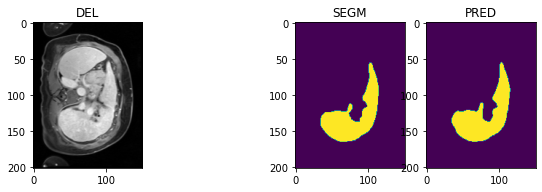

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E100998852_T1_PRE_REG_segm.nii.gz
torch.Size([2, 190, 143, 120])
torch.Size([1, 190, 143, 120])
torch.Size([1, 2, 190, 143, 120])
0.9573610424995422
62.77499491578489
6.585370276914246
torch.Size([2, 190, 143, 120])
torch.Size([1, 190, 143, 120])
torch.Size([1, 2, 190, 143, 120])
0.9751439094543457
1.4142135623730951
0.4511125545543884
torch.Size([1, 2, 190, 143, 120])
torch.Size([1, 190, 143, 120])


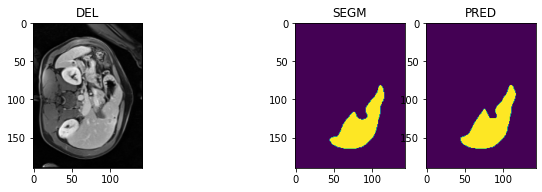

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/12370686_T1_PRE_REG_segm.nii.gz
torch.Size([2, 220, 177, 120])
torch.Size([1, 220, 177, 120])
torch.Size([1, 2, 220, 177, 120])
0.966413676738739
50.20956084253277
3.4978292266061106
torch.Size([2, 220, 177, 120])
torch.Size([1, 220, 177, 120])
torch.Size([1, 2, 220, 177, 120])
0.9705833196640015
1.4142135623730951
0.46260900547421224
torch.Size([1, 2, 220, 177, 120])
torch.Size([1, 220, 177, 120])


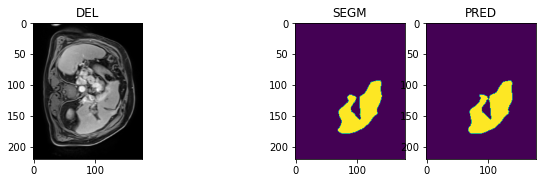

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E104184251_T1_PRE_REG_segm.nii.gz
torch.Size([2, 230, 230, 144])
torch.Size([1, 230, 230, 144])
torch.Size([1, 2, 230, 230, 144])
0.9111884832382202
74.82579739498719
14.064509016321097
torch.Size([2, 230, 230, 144])
torch.Size([1, 230, 230, 144])
torch.Size([1, 2, 230, 230, 144])
0.9425173997879028
2.8284271247461903
0.9720669692452464
torch.Size([1, 2, 230, 230, 144])
torch.Size([1, 230, 230, 144])


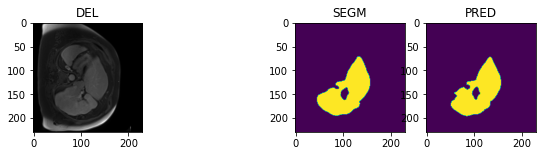

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E100353838_T1_PRE_REG_segm.nii.gz
torch.Size([2, 210, 158, 95])
torch.Size([1, 210, 158, 95])
torch.Size([1, 2, 210, 158, 95])
0.9496316909790039
51.59941791910723
6.981189173339176
torch.Size([2, 210, 158, 95])
torch.Size([1, 210, 158, 95])
torch.Size([1, 2, 210, 158, 95])
0.9584783315658569
2.23606797749979
0.6531589580467029
torch.Size([1, 2, 210, 158, 95])
torch.Size([1, 210, 158, 95])


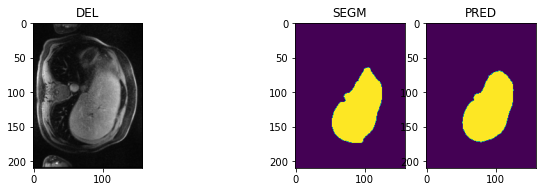

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/11655071_T1_PRE_REG_segm.nii.gz
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.9433236122131348
21.477892965570106
2.9492819366176377
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.9548945426940918
2.0
0.793688596667758
torch.Size([1, 2, 190, 149, 120])
torch.Size([1, 190, 149, 120])


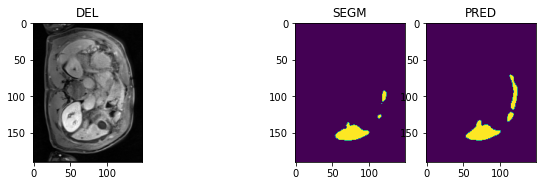

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E105258820_T1_PRE_REG_segm.nii.gz
torch.Size([2, 180, 169, 140])
torch.Size([1, 180, 169, 140])
torch.Size([1, 2, 180, 169, 140])
0.9421764016151428
4.123105625617661
1.69574853740655
torch.Size([2, 180, 169, 140])
torch.Size([1, 180, 169, 140])
torch.Size([1, 2, 180, 169, 140])
0.9427345991134644
4.0
1.1579764550775409
torch.Size([1, 2, 180, 169, 140])
torch.Size([1, 180, 169, 140])


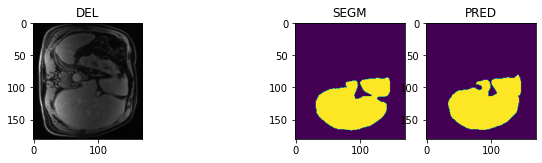

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/10782833_T1_PRE_REG_segm.nii.gz
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.974799633026123
1.0
0.7648492511333037
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.9749595522880554
1.0
0.4242338956218784
torch.Size([1, 2, 190, 149, 120])
torch.Size([1, 190, 149, 120])


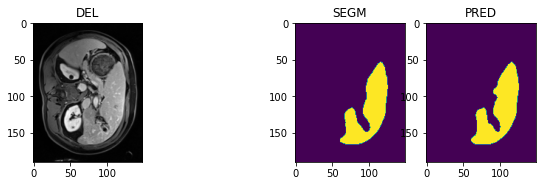

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E105047582_T1_PRE_REG_segm.nii.gz
torch.Size([2, 200, 156, 120])
torch.Size([1, 200, 156, 120])
torch.Size([1, 2, 200, 156, 120])
0.9160343408584595
73.05477397131553
16.84701512622649
torch.Size([2, 200, 156, 120])
torch.Size([1, 200, 156, 120])
torch.Size([1, 2, 200, 156, 120])
0.9578573703765869
1.7320508075688772
0.6279594928102532
torch.Size([1, 2, 200, 156, 120])
torch.Size([1, 200, 156, 120])


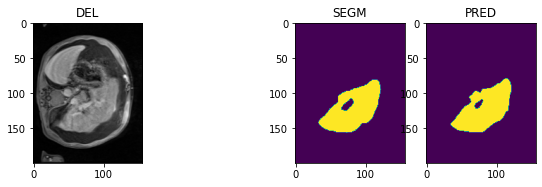

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E100559269_T1_PRE_REG_segm.nii.gz
torch.Size([2, 180, 147, 132])
torch.Size([1, 180, 147, 132])
torch.Size([1, 2, 180, 147, 132])
0.8712267279624939
51.473293817383045
8.180191204782929
torch.Size([2, 180, 147, 132])
torch.Size([1, 180, 147, 132])
torch.Size([1, 2, 180, 147, 132])
0.9432358145713806
3.0
0.8296431757936189
torch.Size([1, 2, 180, 147, 132])
torch.Size([1, 180, 147, 132])


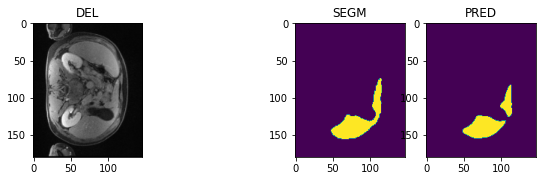

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/11157922_T1_PRE_REG_segm.nii.gz
torch.Size([2, 203, 172, 116])
torch.Size([1, 203, 172, 116])
torch.Size([1, 2, 203, 172, 116])
0.9546909332275391
23.201290966386807
3.4127193560328335
torch.Size([2, 203, 172, 116])
torch.Size([1, 203, 172, 116])
torch.Size([1, 2, 203, 172, 116])
0.9591434597969055
2.23606797749979
0.7729544928584329
torch.Size([1, 2, 203, 172, 116])
torch.Size([1, 203, 172, 116])


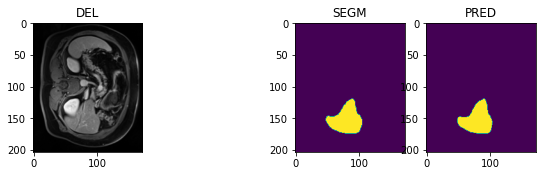

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E103977998_T1_PRE_REG_segm.nii.gz
torch.Size([2, 190, 155, 120])
torch.Size([1, 190, 155, 120])
torch.Size([1, 2, 190, 155, 120])
0.9332505464553833
6.082762530298219
0.9636139897067987
torch.Size([2, 190, 155, 120])
torch.Size([1, 190, 155, 120])
torch.Size([1, 2, 190, 155, 120])
0.9332505464553833
6.082762530298219
0.9636139897067987
torch.Size([1, 2, 190, 155, 120])
torch.Size([1, 190, 155, 120])


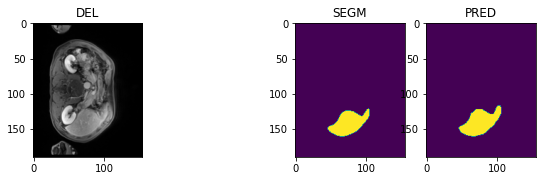

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E106605970_T1_PRE_REG_segm.nii.gz
torch.Size([2, 200, 163, 120])
torch.Size([1, 200, 163, 120])
torch.Size([1, 2, 200, 163, 120])
0.8745326399803162
69.41361530904344
15.839714303067204
torch.Size([2, 200, 163, 120])
torch.Size([1, 200, 163, 120])
torch.Size([1, 2, 200, 163, 120])
0.9517191648483276
4.242640687119285
0.6976415545910455
torch.Size([1, 2, 200, 163, 120])
torch.Size([1, 200, 163, 120])


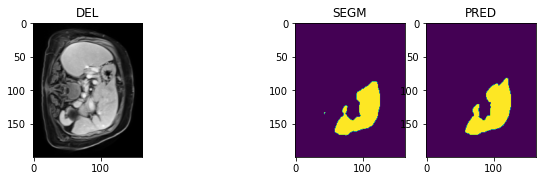

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E101166449_T1_PRE_REG_segm.nii.gz
torch.Size([2, 221, 221, 110])
torch.Size([1, 221, 221, 110])
torch.Size([1, 2, 221, 221, 110])
0.9619805216789246
56.32761077112029
5.677601490162872
torch.Size([2, 221, 221, 110])
torch.Size([1, 221, 221, 110])
torch.Size([1, 2, 221, 221, 110])
0.9725328683853149
1.4142135623730951
0.4590667063224403
torch.Size([1, 2, 221, 221, 110])
torch.Size([1, 221, 221, 110])


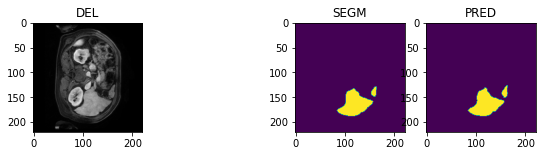

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E101693803_T1_PRE_REG_segm.nii.gz
torch.Size([2, 205, 160, 120])
torch.Size([1, 205, 160, 120])
torch.Size([1, 2, 205, 160, 120])
0.9528447389602661
68.13075625808173
9.189760769990752
torch.Size([2, 205, 160, 120])
torch.Size([1, 205, 160, 120])
torch.Size([1, 2, 205, 160, 120])
0.9659090638160706
1.4142135623730951
0.5296879608057321
torch.Size([1, 2, 205, 160, 120])
torch.Size([1, 205, 160, 120])


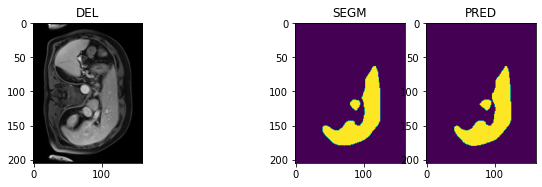

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E100488381_T1_PRE_REG_segm.nii.gz
torch.Size([2, 225, 176, 132])
torch.Size([1, 225, 176, 132])
torch.Size([1, 2, 225, 176, 132])
0.9585041999816895
5.0
2.2076793522094666
torch.Size([2, 225, 176, 132])
torch.Size([1, 225, 176, 132])
torch.Size([1, 2, 225, 176, 132])
0.9606528282165527
5.0
0.5586792518780849
torch.Size([1, 2, 225, 176, 132])
torch.Size([1, 225, 176, 132])


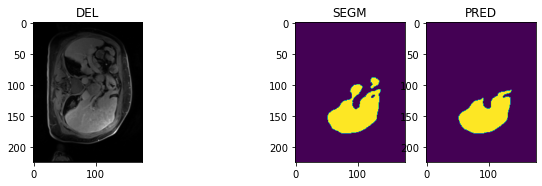

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E101446184_T1_PRE_REG_segm.nii.gz
torch.Size([2, 190, 127, 108])
torch.Size([1, 190, 127, 108])
torch.Size([1, 2, 190, 127, 108])
0.9499528408050537
3.0
0.7158972161470735
torch.Size([2, 190, 127, 108])
torch.Size([1, 190, 127, 108])
torch.Size([1, 2, 190, 127, 108])
0.9499528408050537
3.0
0.7158972161470735
torch.Size([1, 2, 190, 127, 108])
torch.Size([1, 190, 127, 108])


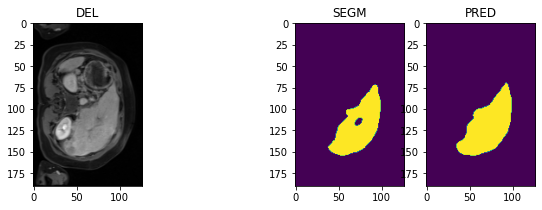

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/12132879_T1_PRE_REG_segm.nii.gz
torch.Size([2, 250, 187, 132])
torch.Size([1, 250, 187, 132])
torch.Size([1, 2, 250, 187, 132])
0.9780435562133789
1.0
0.4084004937266441
torch.Size([2, 250, 187, 132])
torch.Size([1, 250, 187, 132])
torch.Size([1, 2, 250, 187, 132])
0.9780604839324951
1.0
0.37972273468344364
torch.Size([1, 2, 250, 187, 132])
torch.Size([1, 250, 187, 132])


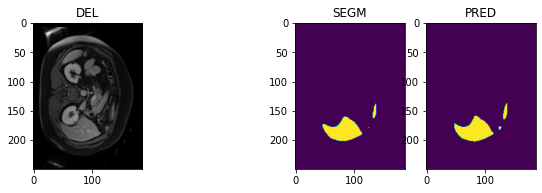

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E100207522_T1_PRE_REG_segm.nii.gz
torch.Size([2, 210, 169, 120])
torch.Size([1, 210, 169, 120])
torch.Size([1, 2, 210, 169, 120])
0.9218566417694092
71.45628033979938
13.629396728272694
torch.Size([2, 210, 169, 120])
torch.Size([1, 210, 169, 120])
torch.Size([1, 2, 210, 169, 120])
0.9679426550865173
1.7320508075688772
0.5965785318112864
torch.Size([1, 2, 210, 169, 120])
torch.Size([1, 210, 169, 120])


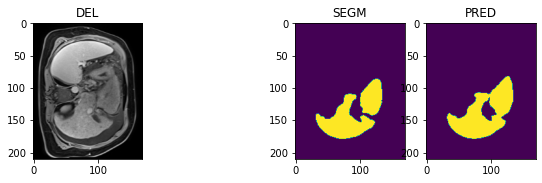

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E104350920_T1_PRE_REG_segm.nii.gz
torch.Size([2, 190, 143, 120])
torch.Size([1, 190, 143, 120])
torch.Size([1, 2, 190, 143, 120])
0.9273617267608643
56.124860801609124
12.253422129978926
torch.Size([2, 190, 143, 120])
torch.Size([1, 190, 143, 120])
torch.Size([1, 2, 190, 143, 120])
0.9480785131454468
2.23606797749979
0.8484452879266963
torch.Size([1, 2, 190, 143, 120])
torch.Size([1, 190, 143, 120])


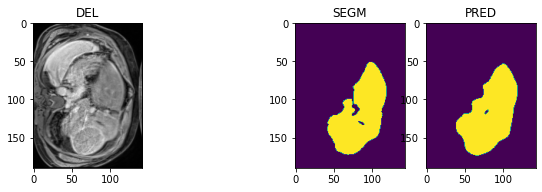

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E103442524_T1_PRE_REG_segm.nii.gz
torch.Size([2, 210, 210, 132])
torch.Size([1, 210, 210, 132])
torch.Size([1, 2, 210, 210, 132])
0.9575240612030029
68.17917419168069
6.987845729587358
torch.Size([2, 210, 210, 132])
torch.Size([1, 210, 210, 132])
torch.Size([1, 2, 210, 210, 132])
0.9727689623832703
1.7320508075688772
0.5469391107162679
torch.Size([1, 2, 210, 210, 132])
torch.Size([1, 210, 210, 132])


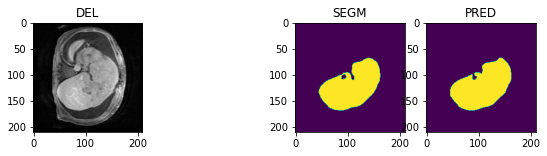

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E100354995_T1_PRE_REG_segm.nii.gz
torch.Size([2, 200, 157, 120])
torch.Size([1, 200, 157, 120])
torch.Size([1, 2, 200, 157, 120])
0.9644476175308228
32.7566787083184
2.932322237439826
torch.Size([2, 200, 157, 120])
torch.Size([1, 200, 157, 120])
torch.Size([1, 2, 200, 157, 120])
0.9724429845809937
1.4142135623730951
0.5015309077566888
torch.Size([1, 2, 200, 157, 120])
torch.Size([1, 200, 157, 120])


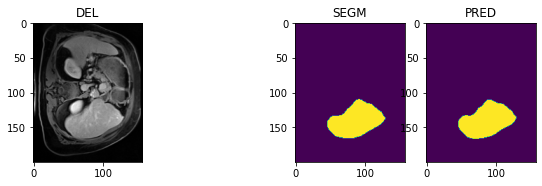

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/12169194_T1_PRE_REG_segm.nii.gz
torch.Size([2, 191, 191, 88])
torch.Size([1, 191, 191, 88])
torch.Size([1, 2, 191, 191, 88])
0.9200725555419922
55.73822732120812
8.692196511281711
torch.Size([2, 191, 191, 88])
torch.Size([1, 191, 191, 88])
torch.Size([1, 2, 191, 191, 88])
0.9698431491851807
1.4142135623730951
0.48387359290607923
torch.Size([1, 2, 191, 191, 88])
torch.Size([1, 191, 191, 88])


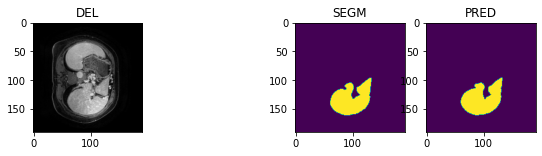

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/9464709_T1_PRE_REG_segm.nii.gz
torch.Size([2, 221, 221, 144])
torch.Size([1, 221, 221, 144])
torch.Size([1, 2, 221, 221, 144])
0.9189103245735168
110.5992761379888
30.614514664019385
torch.Size([2, 221, 221, 144])
torch.Size([1, 221, 221, 144])
torch.Size([1, 2, 221, 221, 144])
0.9710833430290222
1.4142135623730951
0.5117291960310318
torch.Size([1, 2, 221, 221, 144])
torch.Size([1, 221, 221, 144])


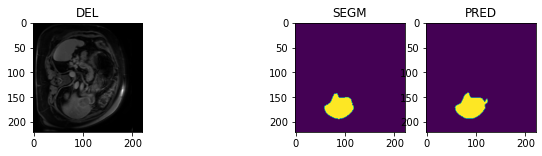

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E102885531_T1_PRE_REG_segm.nii.gz
torch.Size([2, 200, 163, 108])
torch.Size([1, 200, 163, 108])
torch.Size([1, 2, 200, 163, 108])
0.9413729906082153
3.605551275463989
0.8993883553708109
torch.Size([2, 200, 163, 108])
torch.Size([1, 200, 163, 108])
torch.Size([1, 2, 200, 163, 108])
0.9413757920265198
3.605551275463989
0.8926336463304158
torch.Size([1, 2, 200, 163, 108])
torch.Size([1, 200, 163, 108])


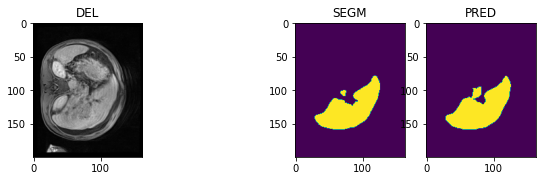

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E106731917_T1_PRE_REG_segm.nii.gz
torch.Size([2, 211, 211, 131])
torch.Size([1, 211, 211, 131])
torch.Size([1, 2, 211, 211, 131])
0.8963061571121216
81.4186710773395
10.724330330414839
torch.Size([2, 211, 211, 131])
torch.Size([1, 211, 211, 131])
torch.Size([1, 2, 211, 211, 131])
0.9208946824073792
9.433981132056603
0.9944152396934697
torch.Size([1, 2, 211, 211, 131])
torch.Size([1, 211, 211, 131])


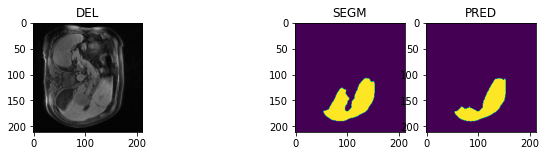

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E105877173_T1_PRE_REG_segm.nii.gz
torch.Size([2, 175, 143, 108])
torch.Size([1, 175, 143, 108])
torch.Size([1, 2, 175, 143, 108])
0.9631952047348022
2.0
0.7532322471410285
torch.Size([2, 175, 143, 108])
torch.Size([1, 175, 143, 108])
torch.Size([1, 2, 175, 143, 108])
0.963394045829773
2.0
0.5906626080299802
torch.Size([1, 2, 175, 143, 108])
torch.Size([1, 175, 143, 108])


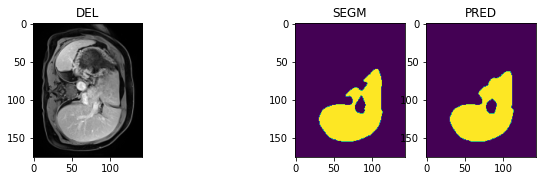

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E106096969_T1_PRE_REG_segm.nii.gz
torch.Size([2, 190, 184, 120])
torch.Size([1, 190, 184, 120])
torch.Size([1, 2, 190, 184, 120])
0.9490893483161926
42.15447781671598
4.529069784896933
torch.Size([2, 190, 184, 120])
torch.Size([1, 190, 184, 120])
torch.Size([1, 2, 190, 184, 120])
0.9572165012359619
2.0
0.6617764569219741
torch.Size([1, 2, 190, 184, 120])
torch.Size([1, 190, 184, 120])


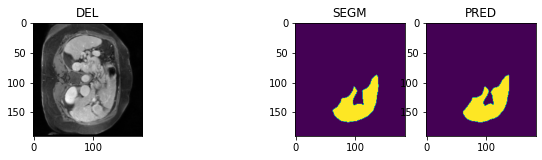

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/11571840_T1_PRE_REG_segm.nii.gz
torch.Size([2, 220, 165, 131])
torch.Size([1, 220, 165, 131])
torch.Size([1, 2, 220, 165, 131])
0.9586184620857239
2.23606797749979
0.6921452192430081
torch.Size([2, 220, 165, 131])
torch.Size([1, 220, 165, 131])
torch.Size([1, 2, 220, 165, 131])
0.9586184620857239
2.23606797749979
0.6921452192430081
torch.Size([1, 2, 220, 165, 131])
torch.Size([1, 220, 165, 131])


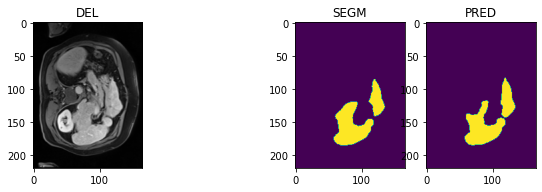

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E101753253_T1_PRE_REG_segm.nii.gz
torch.Size([2, 190, 155, 120])
torch.Size([1, 190, 155, 120])
torch.Size([1, 2, 190, 155, 120])
0.9762254357337952
1.0
0.9653026515577667
torch.Size([2, 190, 155, 120])
torch.Size([1, 190, 155, 120])
torch.Size([1, 2, 190, 155, 120])
0.9768258929252625
1.0
0.40152993288279004
torch.Size([1, 2, 190, 155, 120])
torch.Size([1, 190, 155, 120])


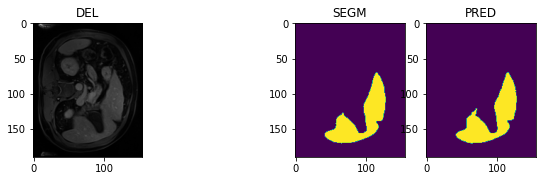

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E103922902_T1_PRE_REG_segm.nii.gz
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.9644761681556702
2.449489742783178
2.4510352128703325
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.9664700031280518
2.23606797749979
0.6108982229568127
torch.Size([1, 2, 210, 164, 120])
torch.Size([1, 210, 164, 120])


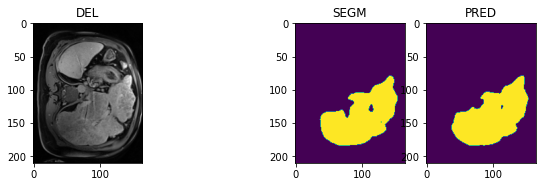

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E101453378_T1_PRE_REG_segm.nii.gz
torch.Size([2, 180, 146, 102])
torch.Size([1, 180, 146, 102])
torch.Size([1, 2, 180, 146, 102])
0.9589945673942566
41.42463035441596
6.13642840650834
torch.Size([2, 180, 146, 102])
torch.Size([1, 180, 146, 102])
torch.Size([1, 2, 180, 146, 102])
0.9683746695518494
1.4142135623730951
0.5662113721766054
torch.Size([1, 2, 180, 146, 102])
torch.Size([1, 180, 146, 102])


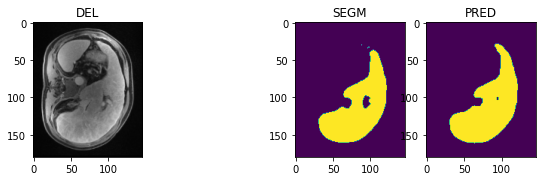

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/11397044_T1_PRE_REG_segm.nii.gz
torch.Size([2, 210, 158, 120])
torch.Size([1, 210, 158, 120])
torch.Size([1, 2, 210, 158, 120])
0.9631795883178711
2.0
2.06329233199824
torch.Size([2, 210, 158, 120])
torch.Size([1, 210, 158, 120])
torch.Size([1, 2, 210, 158, 120])
0.9640492796897888
2.0
0.6026687988888326
torch.Size([1, 2, 210, 158, 120])
torch.Size([1, 210, 158, 120])


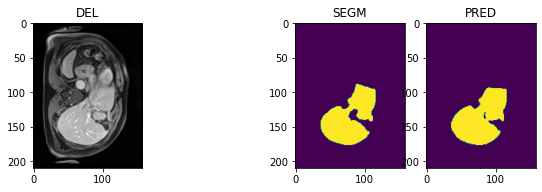

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/12922235_T1_PRE_REG_segm.nii.gz
torch.Size([2, 185, 151, 120])
torch.Size([1, 185, 151, 120])
torch.Size([1, 2, 185, 151, 120])
0.9667503833770752
2.0
0.6148342635382507
torch.Size([2, 185, 151, 120])
torch.Size([1, 185, 151, 120])
torch.Size([1, 2, 185, 151, 120])
0.9668046832084656
2.0
0.5540853815043948
torch.Size([1, 2, 185, 151, 120])
torch.Size([1, 185, 151, 120])


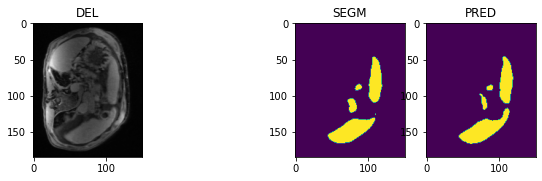

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/10939089_T1_PRE_REG_segm.nii.gz
torch.Size([2, 225, 149, 144])
torch.Size([1, 225, 149, 144])
torch.Size([1, 2, 225, 149, 144])
0.9767885208129883
1.4142135623730951
0.3920537722569421
torch.Size([2, 225, 149, 144])
torch.Size([1, 225, 149, 144])
torch.Size([1, 2, 225, 149, 144])
0.9767906069755554
1.4142135623730951
0.387962683618041
torch.Size([1, 2, 225, 149, 144])
torch.Size([1, 225, 149, 144])


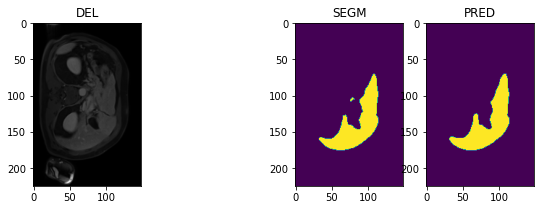

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/12957044_T1_PRE_REG_segm.nii.gz
torch.Size([2, 220, 179, 120])
torch.Size([1, 220, 179, 120])
torch.Size([1, 2, 220, 179, 120])
0.9625199437141418
21.118592640133137
3.9013191128910667
torch.Size([2, 220, 179, 120])
torch.Size([1, 220, 179, 120])
torch.Size([1, 2, 220, 179, 120])
0.9663861393928528
2.0
0.6408368603613291
torch.Size([1, 2, 220, 179, 120])
torch.Size([1, 220, 179, 120])


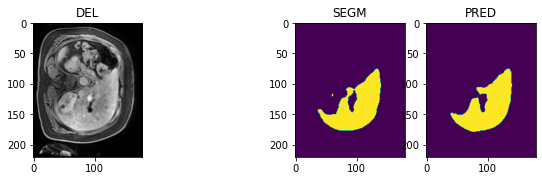

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E107891018_T1_PRE_REG_segm.nii.gz
torch.Size([2, 201, 151, 132])
torch.Size([1, 201, 151, 132])
torch.Size([1, 2, 201, 151, 132])
0.9718306064605713
1.4142135623730951
0.49722576550289443
torch.Size([2, 201, 151, 132])
torch.Size([1, 201, 151, 132])
torch.Size([1, 2, 201, 151, 132])
0.9718306064605713
1.4142135623730951
0.49722576550289443
torch.Size([1, 2, 201, 151, 132])
torch.Size([1, 201, 151, 132])


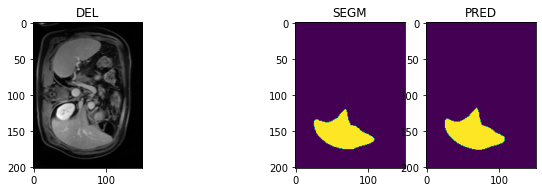

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E104332583_T1_PRE_REG_segm.nii.gz
torch.Size([2, 220, 165, 144])
torch.Size([1, 220, 165, 144])
torch.Size([1, 2, 220, 165, 144])
0.9731312990188599
1.4142135623730951
0.5277735979960261
torch.Size([2, 220, 165, 144])
torch.Size([1, 220, 165, 144])
torch.Size([1, 2, 220, 165, 144])
0.9731312990188599
1.4142135623730951
0.5277735979960261
torch.Size([1, 2, 220, 165, 144])
torch.Size([1, 220, 165, 144])


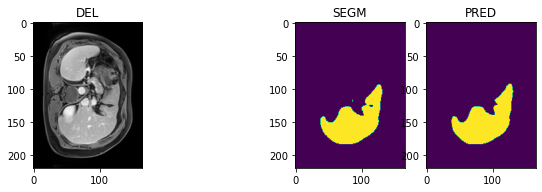

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E101547088_T1_PRE_REG_segm.nii.gz
torch.Size([2, 195, 147, 139])
torch.Size([1, 195, 147, 139])
torch.Size([1, 2, 195, 147, 139])
0.9668653011322021
2.0
2.6216020876744643
torch.Size([2, 195, 147, 139])
torch.Size([1, 195, 147, 139])
torch.Size([1, 2, 195, 147, 139])
0.9701724052429199
1.4142135623730951
0.5190127867786258
torch.Size([1, 2, 195, 147, 139])
torch.Size([1, 195, 147, 139])


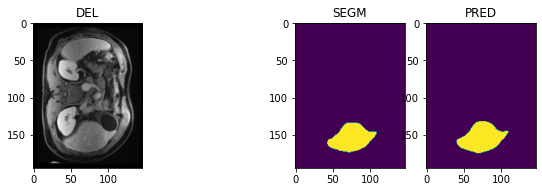

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/11524268_T1_PRE_REG_segm.nii.gz
torch.Size([2, 190, 155, 132])
torch.Size([1, 190, 155, 132])
torch.Size([1, 2, 190, 155, 132])
0.9695340394973755
1.4142135623730951
0.6327438952939801
torch.Size([2, 190, 155, 132])
torch.Size([1, 190, 155, 132])
torch.Size([1, 2, 190, 155, 132])
0.9696508646011353
1.4142135623730951
0.5147328688269428
torch.Size([1, 2, 190, 155, 132])
torch.Size([1, 190, 155, 132])


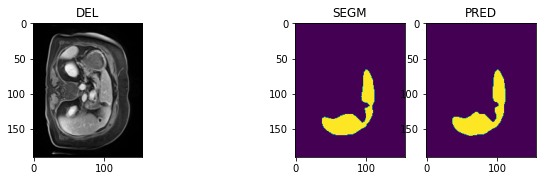

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E106458466_T1_PRE_REG_segm.nii.gz
torch.Size([2, 197, 160, 96])
torch.Size([1, 197, 160, 96])
torch.Size([1, 2, 197, 160, 96])
0.9454809427261353
18.027756377319946
3.581384418249772
torch.Size([2, 197, 160, 96])
torch.Size([1, 197, 160, 96])
torch.Size([1, 2, 197, 160, 96])
0.9488074779510498
2.449489742783178
0.7867094031998308
torch.Size([1, 2, 197, 160, 96])
torch.Size([1, 197, 160, 96])


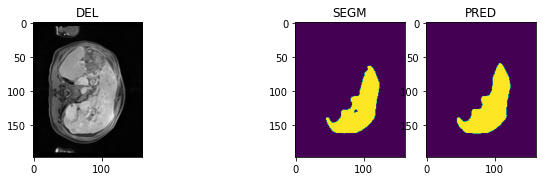

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E107235152_T1_PRE_REG_segm.nii.gz
torch.Size([2, 201, 201, 123])
torch.Size([1, 201, 201, 123])
torch.Size([1, 2, 201, 201, 123])
0.9546881914138794
2.23606797749979
0.740629139780727
torch.Size([2, 201, 201, 123])
torch.Size([1, 201, 201, 123])
torch.Size([1, 2, 201, 201, 123])
0.9546881914138794
2.23606797749979
0.740629139780727
torch.Size([1, 2, 201, 201, 123])
torch.Size([1, 201, 201, 123])


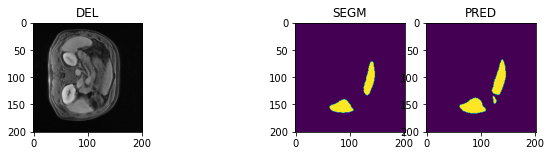

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E105198762_T1_PRE_REG_segm.nii.gz
torch.Size([2, 190, 164, 144])
torch.Size([1, 190, 164, 144])
torch.Size([1, 2, 190, 164, 144])
0.737739086151123
67.30341736978276
18.34979287923774
torch.Size([2, 190, 164, 144])
torch.Size([1, 190, 164, 144])
torch.Size([1, 2, 190, 164, 144])
0.917706310749054
6.4031242374328485
1.626201718218341
torch.Size([1, 2, 190, 164, 144])
torch.Size([1, 190, 164, 144])


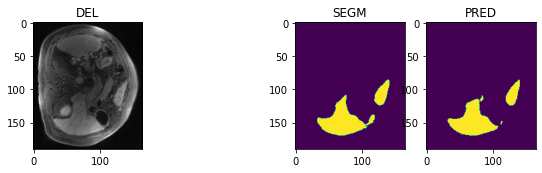

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/11148247_T1_PRE_REG_segm.nii.gz
torch.Size([2, 196, 192, 120])
torch.Size([1, 196, 192, 120])
torch.Size([1, 2, 196, 192, 120])
0.9660314917564392
2.23606797749979
2.0964792079326715
torch.Size([2, 196, 192, 120])
torch.Size([1, 196, 192, 120])
torch.Size([1, 2, 196, 192, 120])
0.9668543338775635
2.0
0.5946798170997641
torch.Size([1, 2, 196, 192, 120])
torch.Size([1, 196, 192, 120])


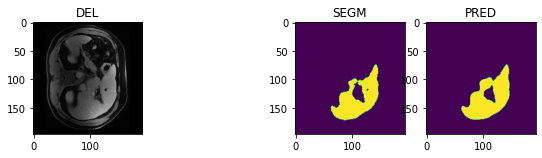

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E106751045_T1_PRE_REG_segm.nii.gz
torch.Size([2, 186, 186, 92])
torch.Size([1, 186, 186, 92])
torch.Size([1, 2, 186, 186, 92])
0.9159685373306274
50.33885179461288
6.096944146742328
torch.Size([2, 186, 186, 92])
torch.Size([1, 186, 186, 92])
torch.Size([1, 2, 186, 186, 92])
0.9376736879348755
6.082762530298219
1.3045382091094897
torch.Size([1, 2, 186, 186, 92])
torch.Size([1, 186, 186, 92])


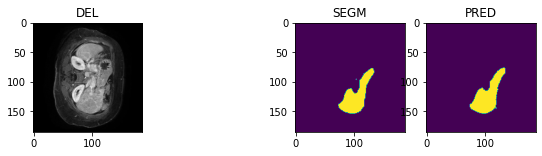

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/9648994_T1_PRE_REG_segm.nii.gz
torch.Size([2, 190, 148, 142])
torch.Size([1, 190, 148, 142])
torch.Size([1, 2, 190, 148, 142])
0.8971459865570068
83.88504027464555
16.13767418968853
torch.Size([2, 190, 148, 142])
torch.Size([1, 190, 148, 142])
torch.Size([1, 2, 190, 148, 142])
0.97195965051651
1.4142135623730951
0.5069145873152957
torch.Size([1, 2, 190, 148, 142])
torch.Size([1, 190, 148, 142])


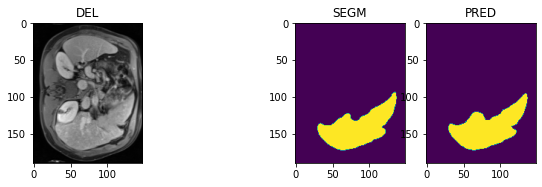

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E102928841_T1_PRE_REG_segm.nii.gz
torch.Size([2, 201, 151, 120])
torch.Size([1, 201, 151, 120])
torch.Size([1, 2, 201, 151, 120])
0.9515793919563293
48.934135300684225
6.261510559851256
torch.Size([2, 201, 151, 120])
torch.Size([1, 201, 151, 120])
torch.Size([1, 2, 201, 151, 120])
0.9602828621864319
2.23606797749979
0.6640811137856638
torch.Size([1, 2, 201, 151, 120])
torch.Size([1, 201, 151, 120])


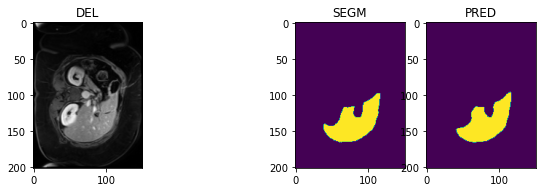

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E105426183_T1_PRE_REG_segm.nii.gz
torch.Size([2, 200, 163, 116])
torch.Size([1, 200, 163, 116])
torch.Size([1, 2, 200, 163, 116])
0.9699530601501465
2.23606797749979
3.4552511156033443
torch.Size([2, 200, 163, 116])
torch.Size([1, 200, 163, 116])
torch.Size([1, 2, 200, 163, 116])
0.9721434712409973
1.4142135623730951
0.5040236501225396
torch.Size([1, 2, 200, 163, 116])
torch.Size([1, 200, 163, 116])


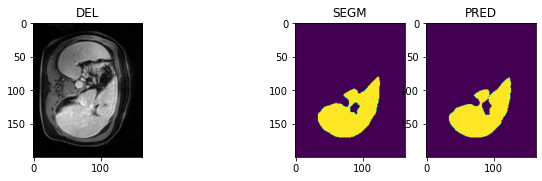

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E100142484_T1_PRE_REG_segm.nii.gz
torch.Size([2, 190, 155, 132])
torch.Size([1, 190, 155, 132])
torch.Size([1, 2, 190, 155, 132])
0.9719648361206055
1.7320508075688772
0.6202179984163804
torch.Size([2, 190, 155, 132])
torch.Size([1, 190, 155, 132])
torch.Size([1, 2, 190, 155, 132])
0.9719648361206055
1.7320508075688772
0.6202179984163804
torch.Size([1, 2, 190, 155, 132])
torch.Size([1, 190, 155, 132])


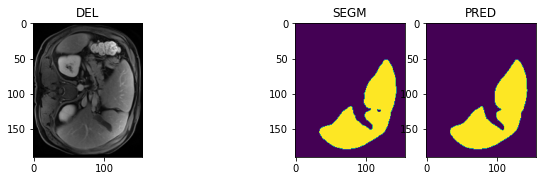

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E105829099_T1_PRE_REG_segm.nii.gz
torch.Size([2, 201, 201, 92])
torch.Size([1, 201, 201, 92])
torch.Size([1, 2, 201, 201, 92])
0.924873948097229
5.0990195135927845
0.9747678111819776
torch.Size([2, 201, 201, 92])
torch.Size([1, 201, 201, 92])
torch.Size([1, 2, 201, 201, 92])
0.9248864650726318
5.0990195135927845
0.9564689646956688
torch.Size([1, 2, 201, 201, 92])
torch.Size([1, 201, 201, 92])


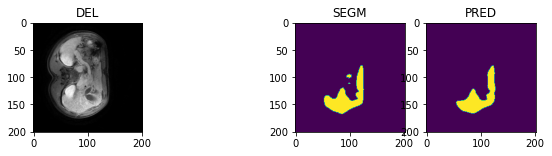

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/9586289_T1_PRE_REG_segm.nii.gz
torch.Size([2, 170, 133, 108])
torch.Size([1, 170, 133, 108])
torch.Size([1, 2, 170, 133, 108])
0.913007378578186
4.58257569495584
0.8019905119126194
torch.Size([2, 170, 133, 108])
torch.Size([1, 170, 133, 108])
torch.Size([1, 2, 170, 133, 108])
0.913007378578186
4.58257569495584
0.8019905119126194
torch.Size([1, 2, 170, 133, 108])
torch.Size([1, 170, 133, 108])


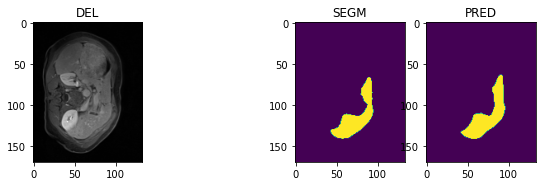

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E107156072_T1_PRE_REG_segm.nii.gz
torch.Size([2, 220, 174, 108])
torch.Size([1, 220, 174, 108])
torch.Size([1, 2, 220, 174, 108])
0.9704667925834656
1.4142135623730951
0.5601970238926167
torch.Size([2, 220, 174, 108])
torch.Size([1, 220, 174, 108])
torch.Size([1, 2, 220, 174, 108])
0.9704667925834656
1.4142135623730951
0.5601970238926167
torch.Size([1, 2, 220, 174, 108])
torch.Size([1, 220, 174, 108])


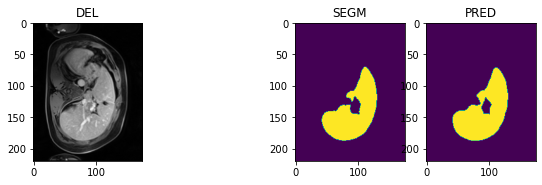

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E104998309_T1_PRE_REG_segm.nii.gz
torch.Size([2, 200, 173, 120])
torch.Size([1, 200, 173, 120])
torch.Size([1, 2, 200, 173, 120])
0.9709354639053345
2.23606797749979
4.105874410360584
torch.Size([2, 200, 173, 120])
torch.Size([1, 200, 173, 120])
torch.Size([1, 2, 200, 173, 120])
0.9761993288993835
1.4142135623730951
0.4696471969711443
torch.Size([1, 2, 200, 173, 120])
torch.Size([1, 200, 173, 120])


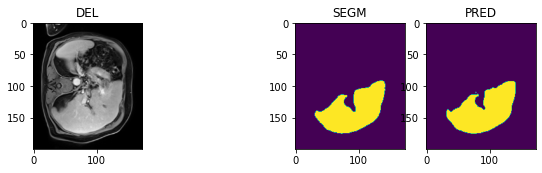

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E105615985_T1_PRE_REG_segm.nii.gz
torch.Size([2, 190, 149, 132])
torch.Size([1, 190, 149, 132])
torch.Size([1, 2, 190, 149, 132])
0.9723140597343445
1.4142135623730951
0.5063028023340456
torch.Size([2, 190, 149, 132])
torch.Size([1, 190, 149, 132])
torch.Size([1, 2, 190, 149, 132])
0.9723140597343445
1.4142135623730951
0.5063028023340456
torch.Size([1, 2, 190, 149, 132])
torch.Size([1, 190, 149, 132])


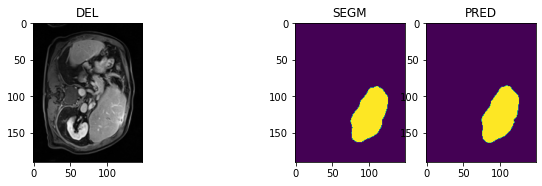

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/12916368_T1_PRE_REG_segm.nii.gz
torch.Size([2, 211, 181, 116])
torch.Size([1, 211, 181, 116])
torch.Size([1, 2, 211, 181, 116])
0.9684327840805054
50.78385570237849
6.302436822104573
torch.Size([2, 211, 181, 116])
torch.Size([1, 211, 181, 116])
torch.Size([1, 2, 211, 181, 116])
0.9757024049758911
1.4142135623730951
0.576902368280077
torch.Size([1, 2, 211, 181, 116])
torch.Size([1, 211, 181, 116])


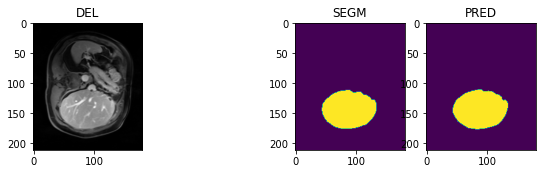

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E103814356_T1_PRE_REG_segm.nii.gz
torch.Size([2, 170, 144, 150])
torch.Size([1, 170, 144, 150])
torch.Size([1, 2, 170, 144, 150])
0.9508805871009827
3.0
1.850193545989149
torch.Size([2, 170, 144, 150])
torch.Size([1, 170, 144, 150])
torch.Size([1, 2, 170, 144, 150])
0.9518061280250549
2.23606797749979
0.8504253377270488
torch.Size([1, 2, 170, 144, 150])
torch.Size([1, 170, 144, 150])


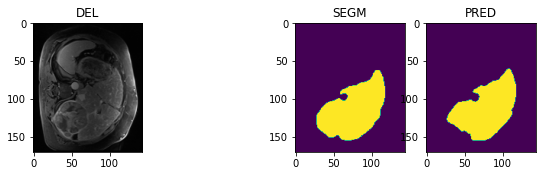

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/11022925_T1_PRE_REG_segm.nii.gz
torch.Size([2, 206, 206, 110])
torch.Size([1, 206, 206, 110])
torch.Size([1, 2, 206, 206, 110])
0.8673359751701355
79.8326370214436
23.125703026088342
torch.Size([2, 206, 206, 110])
torch.Size([1, 206, 206, 110])
torch.Size([1, 2, 206, 206, 110])
0.9659022092819214
2.0
0.5663722418476902
torch.Size([1, 2, 206, 206, 110])
torch.Size([1, 206, 206, 110])


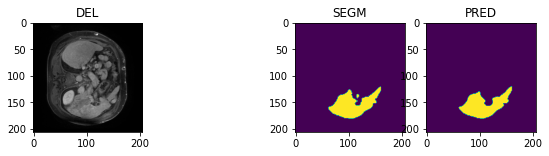

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E106533478_T1_PRE_REG_segm.nii.gz
torch.Size([2, 191, 143, 132])
torch.Size([1, 191, 143, 132])
torch.Size([1, 2, 191, 143, 132])
0.9644266366958618
1.4142135623730951
1.053171305279285
torch.Size([2, 191, 143, 132])
torch.Size([1, 191, 143, 132])
torch.Size([1, 2, 191, 143, 132])
0.9655391573905945
1.4142135623730951
0.5499635215039715
torch.Size([1, 2, 191, 143, 132])
torch.Size([1, 191, 143, 132])


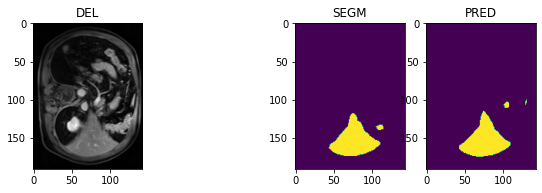

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E106851724_T1_PRE_REG_segm.nii.gz
torch.Size([2, 181, 181, 135])
torch.Size([1, 181, 181, 135])
torch.Size([1, 2, 181, 181, 135])
0.8628528118133545
57.184349637704386
11.971731479829122
torch.Size([2, 181, 181, 135])
torch.Size([1, 181, 181, 135])
torch.Size([1, 2, 181, 181, 135])
0.953487753868103
2.449489742783178
0.8981802876927111
torch.Size([1, 2, 181, 181, 135])
torch.Size([1, 181, 181, 135])


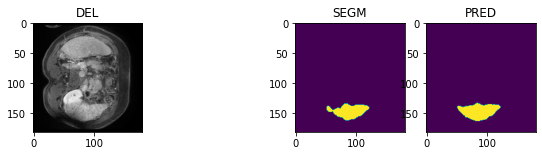

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E103511968_T1_PRE_REG_segm.nii.gz
torch.Size([2, 215, 173, 120])
torch.Size([1, 215, 173, 120])
torch.Size([1, 2, 215, 173, 120])
0.9644524455070496
30.182758361419463
3.4217905189080753
torch.Size([2, 215, 173, 120])
torch.Size([1, 215, 173, 120])
torch.Size([1, 2, 215, 173, 120])
0.9720985293388367
1.4142135623730951
0.48539086182246105
torch.Size([1, 2, 215, 173, 120])
torch.Size([1, 215, 173, 120])


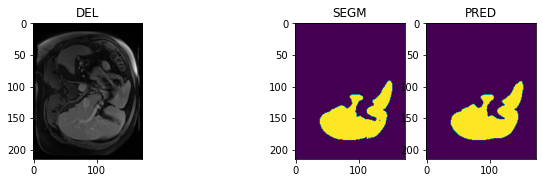

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E107553107_T1_PRE_REG_segm.nii.gz
torch.Size([2, 201, 151, 111])
torch.Size([1, 201, 151, 111])
torch.Size([1, 2, 201, 151, 111])
0.9630619883537292
38.212563020715045
4.601952512205196
torch.Size([2, 201, 151, 111])
torch.Size([1, 201, 151, 111])
torch.Size([1, 2, 201, 151, 111])
0.9671890139579773
1.7320508075688772
0.47166702361816354
torch.Size([1, 2, 201, 151, 111])
torch.Size([1, 201, 151, 111])


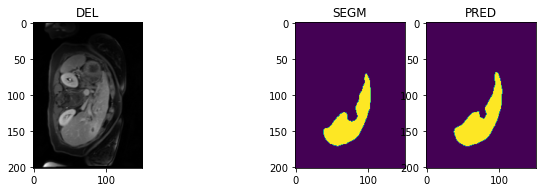

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E100588448_T1_PRE_REG_segm.nii.gz
torch.Size([2, 236, 232, 120])
torch.Size([1, 236, 232, 120])
torch.Size([1, 2, 236, 232, 120])
0.9504790306091309
55.73732879084501
5.426800151854753
torch.Size([2, 236, 232, 120])
torch.Size([1, 236, 232, 120])
torch.Size([1, 2, 236, 232, 120])
0.9587713479995728
5.0
0.6901875193578374
torch.Size([1, 2, 236, 232, 120])
torch.Size([1, 236, 232, 120])


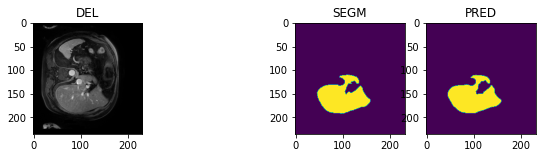

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E104134228_T1_PRE_REG_segm.nii.gz
torch.Size([2, 211, 211, 110])
torch.Size([1, 211, 211, 110])
torch.Size([1, 2, 211, 211, 110])
0.8979595899581909
99.33378071371092
28.08445298189946
torch.Size([2, 211, 211, 110])
torch.Size([1, 211, 211, 110])
torch.Size([1, 2, 211, 211, 110])
0.9625624418258667
1.7320508075688772
0.5664306055138093
torch.Size([1, 2, 211, 211, 110])
torch.Size([1, 211, 211, 110])


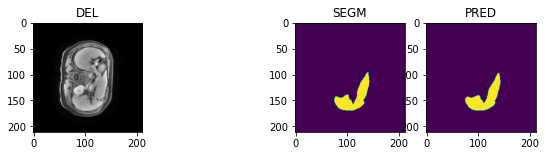

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E101686218_T1_PRE_REG_segm.nii.gz
torch.Size([2, 210, 181, 108])
torch.Size([1, 210, 181, 108])
torch.Size([1, 2, 210, 181, 108])
0.9678710103034973
2.0
1.4275499580455582
torch.Size([2, 210, 181, 108])
torch.Size([1, 210, 181, 108])
torch.Size([1, 2, 210, 181, 108])
0.9692338705062866
2.0
0.5963222426432057
torch.Size([1, 2, 210, 181, 108])
torch.Size([1, 210, 181, 108])


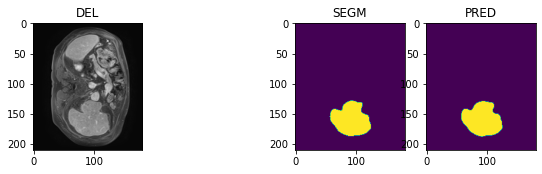

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E100967188_T1_PRE_REG_segm.nii.gz
torch.Size([2, 225, 181, 131])
torch.Size([1, 225, 181, 131])
torch.Size([1, 2, 225, 181, 131])
0.9570594429969788
53.637673327615545
5.737527320667589
torch.Size([2, 225, 181, 131])
torch.Size([1, 225, 181, 131])
torch.Size([1, 2, 225, 181, 131])
0.9726235866546631
1.4142135623730951
0.5865138602338653
torch.Size([1, 2, 225, 181, 131])
torch.Size([1, 225, 181, 131])


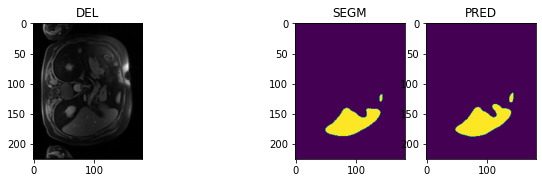

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E107476766_T1_PRE_REG_segm.nii.gz
torch.Size([2, 200, 161, 115])
torch.Size([1, 200, 161, 115])
torch.Size([1, 2, 200, 161, 115])
0.856092095375061
82.86857016606935
32.73337329369437
torch.Size([2, 200, 161, 115])
torch.Size([1, 200, 161, 115])
torch.Size([1, 2, 200, 161, 115])
0.9530155062675476
1.7320508075688772
0.6043484821300416
torch.Size([1, 2, 200, 161, 115])
torch.Size([1, 200, 161, 115])


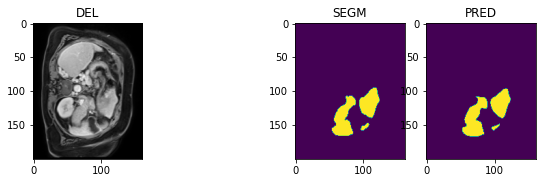

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E104250009_T1_PRE_REG_segm.nii.gz
torch.Size([2, 200, 156, 132])
torch.Size([1, 200, 156, 132])
torch.Size([1, 2, 200, 156, 132])
0.9781747460365295
1.4142135623730951
0.9982516100697361
torch.Size([2, 200, 156, 132])
torch.Size([1, 200, 156, 132])
torch.Size([1, 2, 200, 156, 132])
0.9787221550941467
1.4142135623730951
0.4092500355008654
torch.Size([1, 2, 200, 156, 132])
torch.Size([1, 200, 156, 132])


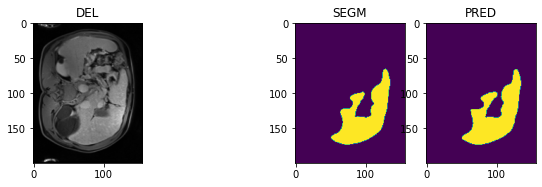

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E105152299_T1_PRE_REG_segm.nii.gz
torch.Size([2, 192, 192, 108])
torch.Size([1, 192, 192, 108])
torch.Size([1, 2, 192, 192, 108])
0.9174588918685913
52.89328127366854
8.77416915998712
torch.Size([2, 192, 192, 108])
torch.Size([1, 192, 192, 108])
torch.Size([1, 2, 192, 192, 108])
0.9621272683143616
1.7320508075688772
0.5742320603697737
torch.Size([1, 2, 192, 192, 108])
torch.Size([1, 192, 192, 108])


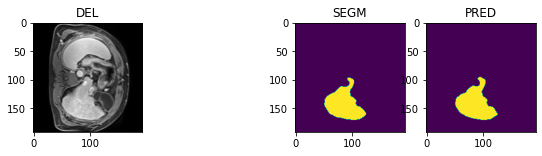

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/11308203_T1_PRE_REG_segm.nii.gz
torch.Size([2, 201, 151, 120])
torch.Size([1, 201, 151, 120])
torch.Size([1, 2, 201, 151, 120])
0.9740585088729858
1.4142135623730951
0.5046644549295699
torch.Size([2, 201, 151, 120])
torch.Size([1, 201, 151, 120])
torch.Size([1, 2, 201, 151, 120])
0.9740657806396484
1.4142135623730951
0.4987754245065288
torch.Size([1, 2, 201, 151, 120])
torch.Size([1, 201, 151, 120])


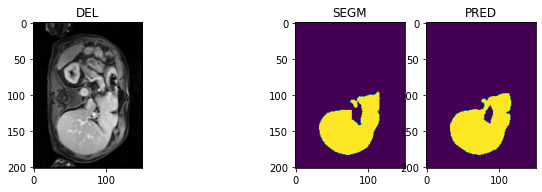

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E107046127_T1_PRE_REG_segm.nii.gz
torch.Size([2, 230, 180, 120])
torch.Size([1, 230, 180, 120])
torch.Size([1, 2, 230, 180, 120])
0.9022239446640015
10.295630140987
1.2648513123000384
torch.Size([2, 230, 180, 120])
torch.Size([1, 230, 180, 120])
torch.Size([1, 2, 230, 180, 120])
0.9023790955543518
10.295630140987
1.1688533887603312
torch.Size([1, 2, 230, 180, 120])
torch.Size([1, 230, 180, 120])


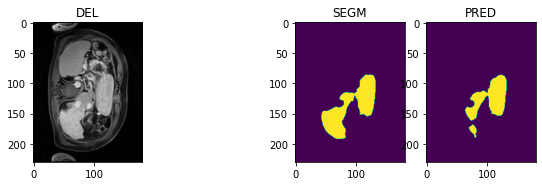

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/13106408_T1_PRE_REG_segm.nii.gz
torch.Size([2, 210, 158, 120])
torch.Size([1, 210, 158, 120])
torch.Size([1, 2, 210, 158, 120])
0.9628257751464844
2.0
2.1760669799826147
torch.Size([2, 210, 158, 120])
torch.Size([1, 210, 158, 120])
torch.Size([1, 2, 210, 158, 120])
0.966628909111023
1.4142135623730951
0.4667421979721437
torch.Size([1, 2, 210, 158, 120])
torch.Size([1, 210, 158, 120])


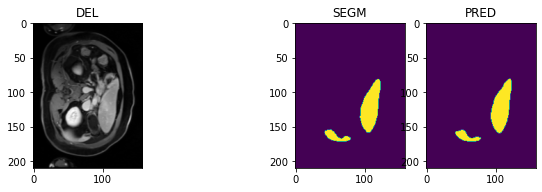

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E102486953_T1_PRE_REG_segm.nii.gz
torch.Size([2, 170, 149, 120])
torch.Size([1, 170, 149, 120])
torch.Size([1, 2, 170, 149, 120])
0.7833875417709351
59.16924876994806
16.99144199290052
torch.Size([2, 170, 149, 120])
torch.Size([1, 170, 149, 120])
torch.Size([1, 2, 170, 149, 120])
0.955693244934082
2.23606797749979
0.5777942119628748
torch.Size([1, 2, 170, 149, 120])
torch.Size([1, 170, 149, 120])


Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E101055640_T1_PRE_REG_segm.nii.gz
torch.Size([2, 200, 137, 120])
torch.Size([1, 200, 137, 120])
torch.Size([1, 2, 200, 137, 120])
0.9530075788497925
10.198039027185569
0.635426365930882
torch.Size([2, 200, 137, 120])
torch.Size([1, 200, 137, 120])
torch.Size([1, 2, 200, 137, 120])
0.9530075788497925
10.198039027185569
0.635426365930882
torch.Size([1, 2, 200, 137, 120])
torch.Size([1, 200, 137, 120])


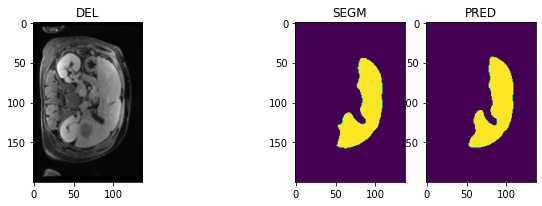

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/10807315_T1_PRE_REG_segm.nii.gz
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.8208782076835632
64.51743938645569
15.001149803987035
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.9738022089004517
1.4142135623730951
0.4218973787915149
torch.Size([1, 2, 210, 164, 120])
torch.Size([1, 210, 164, 120])


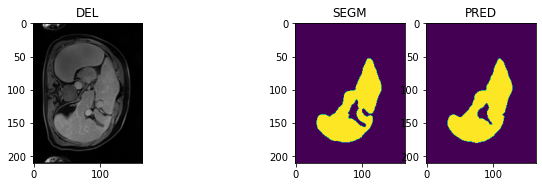

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/13170972_T1_PRE_REG_segm.nii.gz
torch.Size([2, 205, 154, 155])
torch.Size([1, 205, 154, 155])
torch.Size([1, 2, 205, 154, 155])
0.9330043792724609
38.12544822681617
5.908013778001772
torch.Size([2, 205, 154, 155])
torch.Size([1, 205, 154, 155])
torch.Size([1, 2, 205, 154, 155])
0.9409173130989075
5.744562646538029
1.2741462432649917
torch.Size([1, 2, 205, 154, 155])
torch.Size([1, 205, 154, 155])


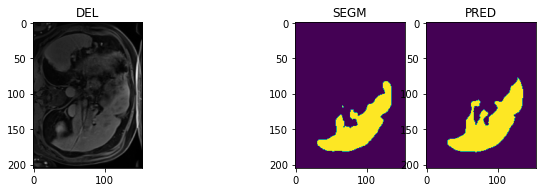

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E104594843_T1_PRE_REG_segm.nii.gz
torch.Size([2, 231, 231, 144])
torch.Size([1, 231, 231, 144])
torch.Size([1, 2, 231, 231, 144])
0.9720337986946106
1.7320508075688772
0.8152664707718037
torch.Size([2, 231, 231, 144])
torch.Size([1, 231, 231, 144])
torch.Size([1, 2, 231, 231, 144])
0.9722656011581421
1.7320508075688772
0.5500749409110222
torch.Size([1, 2, 231, 231, 144])
torch.Size([1, 231, 231, 144])


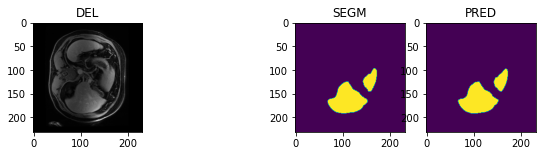

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E104034609_T1_PRE_REG_segm.nii.gz
torch.Size([2, 191, 141, 120])
torch.Size([1, 191, 141, 120])
torch.Size([1, 2, 191, 141, 120])
0.9647947549819946
1.7320508075688772
1.5917170253470376
torch.Size([2, 191, 141, 120])
torch.Size([1, 191, 141, 120])
torch.Size([1, 2, 191, 141, 120])
0.9662168025970459
1.7320508075688772
0.60496313817934
torch.Size([1, 2, 191, 141, 120])
torch.Size([1, 191, 141, 120])


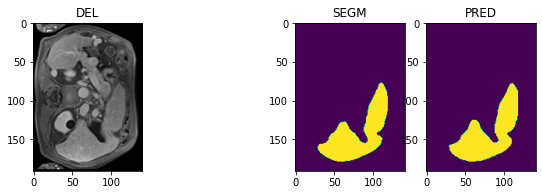

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E107774979_T1_PRE_REG_segm.nii.gz
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.965164303779602
2.449489742783178
3.2184284148324633
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.9696606993675232
1.4142135623730951
0.47205459807946915
torch.Size([1, 2, 210, 164, 120])
torch.Size([1, 210, 164, 120])


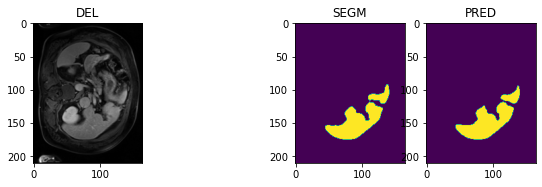

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E104900599_T1_PRE_REG_segm.nii.gz
torch.Size([2, 230, 180, 142])
torch.Size([1, 230, 180, 142])
torch.Size([1, 2, 230, 180, 142])
0.9722025394439697
1.4142135623730951
0.5047121912462407
torch.Size([2, 230, 180, 142])
torch.Size([1, 230, 180, 142])
torch.Size([1, 2, 230, 180, 142])
0.9722236394882202
1.4142135623730951
0.5011342325761683
torch.Size([1, 2, 230, 180, 142])
torch.Size([1, 230, 180, 142])


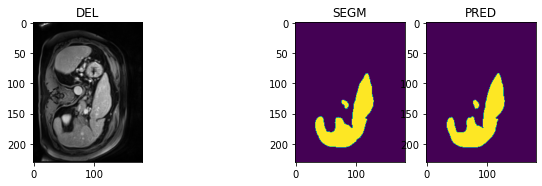

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E104657225_T1_PRE_REG_segm.nii.gz
torch.Size([2, 180, 135, 108])
torch.Size([1, 180, 135, 108])
torch.Size([1, 2, 180, 135, 108])
0.9479913115501404
5.0
0.8264032209350683
torch.Size([2, 180, 135, 108])
torch.Size([1, 180, 135, 108])
torch.Size([1, 2, 180, 135, 108])
0.9480072855949402
5.0
0.7973723852205967
torch.Size([1, 2, 180, 135, 108])
torch.Size([1, 180, 135, 108])


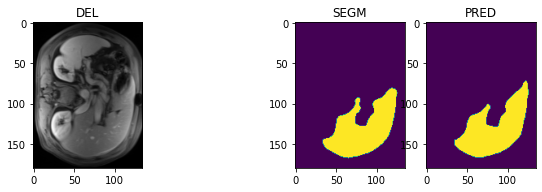

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E105599954_T1_PRE_REG_segm.nii.gz
torch.Size([2, 235, 183, 132])
torch.Size([1, 235, 183, 132])
torch.Size([1, 2, 235, 183, 132])
0.9138082265853882
67.7864293203293
8.899403871203884
torch.Size([2, 235, 183, 132])
torch.Size([1, 235, 183, 132])
torch.Size([1, 2, 235, 183, 132])
0.9255776405334473
18.466185312619388
2.913691003006817
torch.Size([1, 2, 235, 183, 132])
torch.Size([1, 235, 183, 132])


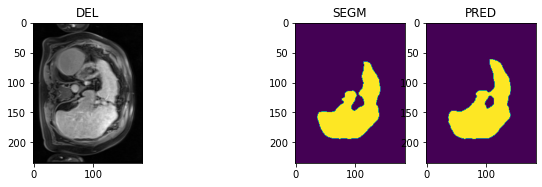

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E103570649_T1_PRE_REG_segm.nii.gz
torch.Size([2, 200, 156, 127])
torch.Size([1, 200, 156, 127])
torch.Size([1, 2, 200, 156, 127])
0.9687519669532776
1.4142135623730951
0.5021554924636126
torch.Size([2, 200, 156, 127])
torch.Size([1, 200, 156, 127])
torch.Size([1, 2, 200, 156, 127])
0.9687519669532776
1.4142135623730951
0.5021554924636126
torch.Size([1, 2, 200, 156, 127])
torch.Size([1, 200, 156, 127])


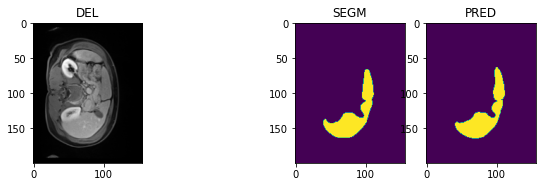

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E105504009_T1_PRE_REG_segm.nii.gz
torch.Size([2, 211, 152, 104])
torch.Size([1, 211, 152, 104])
torch.Size([1, 2, 211, 152, 104])
0.9625763893127441
1.7320508075688772
0.6821811493177863
torch.Size([2, 211, 152, 104])
torch.Size([1, 211, 152, 104])
torch.Size([1, 2, 211, 152, 104])
0.9625781774520874
1.7320508075688772
0.6774506228956317
torch.Size([1, 2, 211, 152, 104])
torch.Size([1, 211, 152, 104])


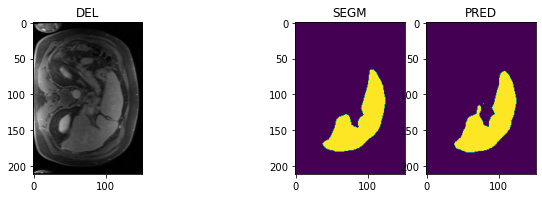

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E103831361_T1_PRE_REG_segm.nii.gz
torch.Size([2, 221, 221, 119])
torch.Size([1, 221, 221, 119])
torch.Size([1, 2, 221, 221, 119])
0.8665730953216553
108.34205093129813
43.43325879662915
torch.Size([2, 221, 221, 119])
torch.Size([1, 221, 221, 119])
torch.Size([1, 2, 221, 221, 119])
0.9591071605682373
2.0
0.7427697610567261
torch.Size([1, 2, 221, 221, 119])
torch.Size([1, 221, 221, 119])


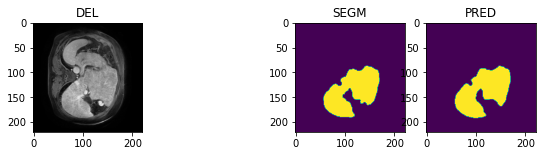

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/10843891_T1_PRE_REG_segm.nii.gz
torch.Size([2, 175, 137, 120])
torch.Size([1, 175, 137, 120])
torch.Size([1, 2, 175, 137, 120])
0.9481711983680725
21.6794833886788
3.0509076748977804
torch.Size([2, 175, 137, 120])
torch.Size([1, 175, 137, 120])
torch.Size([1, 2, 175, 137, 120])
0.9546175003051758
2.23606797749979
0.7911039698996091
torch.Size([1, 2, 175, 137, 120])
torch.Size([1, 175, 137, 120])


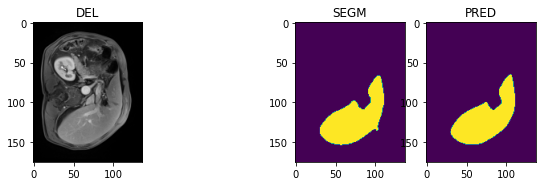

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E101762106_T1_PRE_REG_segm.nii.gz
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.8871042728424072
85.56868586112562
18.727173834087722
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.9628489017486572
1.7320508075688772
0.5920697898175826
torch.Size([1, 2, 190, 149, 120])
torch.Size([1, 190, 149, 120])


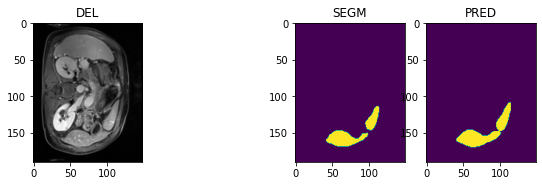

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/12543786_T1_PRE_REG_segm.nii.gz
torch.Size([2, 200, 163, 120])
torch.Size([1, 200, 163, 120])
torch.Size([1, 2, 200, 163, 120])
0.949367880821228
6.6332495807108
4.043100204884329
torch.Size([2, 200, 163, 120])
torch.Size([1, 200, 163, 120])
torch.Size([1, 2, 200, 163, 120])
0.951421856880188
2.8284271247461903
0.8341961190803195
torch.Size([1, 2, 200, 163, 120])
torch.Size([1, 200, 163, 120])


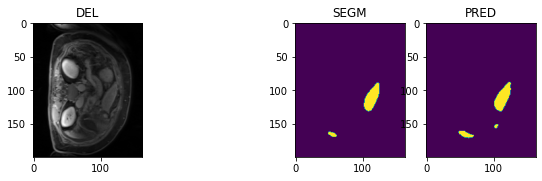

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E107077373_T1_PRE_REG_segm.nii.gz
torch.Size([2, 220, 172, 120])
torch.Size([1, 220, 172, 120])
torch.Size([1, 2, 220, 172, 120])
0.9642495512962341
49.13755489980335
4.927738016416759
torch.Size([2, 220, 172, 120])
torch.Size([1, 220, 172, 120])
torch.Size([1, 2, 220, 172, 120])
0.9718461036682129
1.4142135623730951
0.46868522656849393
torch.Size([1, 2, 220, 172, 120])
torch.Size([1, 220, 172, 120])


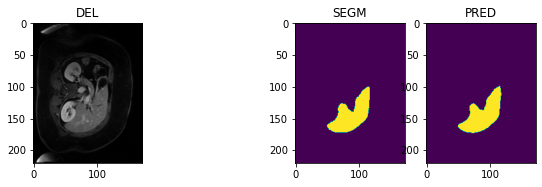

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-DEL/E106501028_T1_PRE_REG_segm.nii.gz
[0.963862955570221, 0.9573610424995422, 0.966413676738739, 0.9111884832382202, 0.9496316909790039, 0.9433236122131348, 0.9421764016151428, 0.974799633026123, 0.9160343408584595, 0.8712267279624939, 0.9546909332275391, 0.9332505464553833, 0.8745326399803162, 0.9619805216789246, 0.9528447389602661, 0.9585041999816895, 0.9499528408050537, 0.9780435562133789, 0.9218566417694092, 0.9273617267608643, 0.9575240612030029, 0.9644476175308228, 0.9200725555419922, 0.9189103245735168, 0.9413729906082153, 0.8963061571121216, 0.9631952047348022, 0.9490893483161926, 0.9586184620857239, 0.9762254357337952, 0.9644761681556702, 0.9589945673942566, 0.9631795883178711, 0.9667503833770752, 0.9767885208129883, 0.9625199437141418, 0.9718306064605713, 0.9731312990188599, 0.9668653011322021, 0.9695340394973755, 0.9454809427261353, 0.9546881914138794, 0.737739086151123, 0.96603149175

DICE  POST_DICE       HD95  POST_HD95  InferenceTime  \
0  0.963863   0.963863   1.414214   1.414214       0.007360   
1  0.957361   0.975144  62.774995   1.414214       0.007121   
2  0.966414   0.970583  50.209561   1.414214       0.005326   
3  0.911188   0.942517  74.825797   2.828427       0.014248   
4  0.949632   0.958478  51.599418   2.236068       0.007852   

                                AUTOMATED-LIVER-SEGM   EXPERIMENT_ID  
0  /tensor5/data1/mgross/Liver/studies/Contrast-N...  2mpMRI-PRE-DEL  
1  /tensor5/data1/mgross/Liver/studies/Contrast-N...  2mpMRI-PRE-DEL  
2  /tensor5/data1/mgross/Liver/studies/Contrast-N...  2mpMRI-PRE-DEL  
3  /tensor5/data1/mgross/Liver/studies/Contrast-N...  2mpMRI-PRE-DEL  
4  /tensor5/data1/mgross/Liver/studies/Contrast-N...  2mpMRI-PRE-DEL

In [51]:
roi_size = (224, 224, 128)

df_test_results = run_inference_and_evaluate(
        model=model, 
        data_loader= test_loader, 
        roi_size=roi_size, 
        plot_images=True, 
        save_output=True,
    output_path= OUTPUT_PATH)
    #max_eval = 2)


torch.cuda.empty_cache()
df_test_results['EXPERIMENT_ID'] = '2mpMRI-PRE-DEL'
df_test_results.head()

In [53]:
df_test_results.to_csv('../Results/Results-2mpMRI-Net_PRE-DEL.csv')

## External Testing

In [37]:
from monai.data import Dataset, DataLoader, pad_list_data_collate

def compute_evaluation_metrics(y_pred, y, keep=False):
    
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    hd = monai.metrics.HausdorffDistanceMetric(include_background=False, reduction="mean", percentile=95, get_not_nans=False)
    mad = monai.metrics.SurfaceDistanceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep_largest = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    dice_list = list()
    hd_list = list()
    mad_list = list()
    for y_pred_i, y_i in decollate_batch((y_pred, y)):
        print(y_pred_i.shape)
        print(y_i.shape)
        if keep:
            #dice(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            #hd(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            #mad(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            y_pred_i_proc=one_hot(keep_largest(argmax(y_pred_i)))
        else:
                
            # Calculate Dice on the raw output
            #dice(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            #hd(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            #mad(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            y_pred_i_proc = one_hot(argmax(y_pred_i))
        y_pred_i_proc = monai.transforms.AddChannel()(y_pred_i_proc)
        y_i_proc = monai.transforms.AddChannel()(one_hot(y_i))
        print(y_pred_i_proc.shape)
            
        #dice(y_pred=y_pred_i_proc, y=one_hot(y_i))
        #hd(y_pred=y_pred_i_proc, y=one_hot(y_i))
        #mad(y_pred=y_pred_i_proc, y=one_hot(y_i))
            
        dice(y_pred=y_pred_i_proc, y=y_i_proc)
        hd(y_pred=y_pred_i_proc, y=y_i_proc)
        mad(y_pred=y_pred_i_proc, y=y_i_proc)
        
        dice_value = dice.aggregate().item()
        hd_value = hd.aggregate().item()
        mad_value = mad.aggregate().item()
        
        print(dice_value)
        print(hd_value)
        print(mad_value)
        
        dice_list.append(dice_value)
        hd_list.append(hd_value)
        mad_list.append(mad_value)
              
    return dice_list, hd_list, mad_list


def run_inference_and_evaluate(model, data_loader, plot_images=False, max_eval=None, 
                               save_output=False,roi_size=(224,224,128), sw_batch_size=4, output_path=None):
    
    """Inference and evaluation function for Liver segmentation.
    
    """   
    
    df_eval = pd.DataFrame()
    
    acc_ids = list()
    input_paths = list()
    output_paths = list()
    
    original_dice_results = list()
    postprocess_dice_results = list()

    original_hd_results = list()
    postprocess_hd_results = list()

    original_mad_results = list()
    postprocess_mad_results = list()
    
    inference_times = list()
    


    
    # Use MONAI one_hot transform
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    with torch.no_grad():
        for i, test_data in tqdm(enumerate(data_loader)):
        # Early stopping
            if max_eval is not None:
                if i>=max_eval:
                    break

            #print(test_data['ACCESSION_ID'][0])
            #for val in test_data['ACCESSION_ID'][0]:
            #    acc_ids.append(val)

    
            pre_images =  test_data["PRE"].to(device)
            del_images =  test_data["DEL"].to(device)
            
            
            x = torch.cat((pre_images, del_images) ,dim=1)
            y = test_data['SEGM'].cpu()




            stpre_time = time.time()
            y_pred = sliding_window_inference(x, roi_size, sw_batch_size, model)
            stop_time = time.time()

            inference_time = stop_time-stpre_time
            inference_times.append(inference_time)

            x = x.detach().cpu()
            y_pred = y_pred.detach().cpu()
            #print(y_pred.shape)

            #argmax = torch.argmax(y_pred, dim=1, keepdim=True)
            #argmax = argmax.detach().cpu()

            #y_onehot = one_hot(y)
            #y_pred_onehot = one_hot(argmax)

            # Evaluate segmentation metrics
            eval_list = list()
            # Update to MONAI 0.7+
            dice_values, hd_values, mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y
            )

            for val in dice_values:
                original_dice_results.append(val)
            for val in hd_values:
                original_hd_results.append(val)
            for val in mad_values:
                original_mad_results.append(val)



            post_dice_values, post_hd_values, post_mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y, keep=True
            )        #dice_list = list()
            #post_dice_list = list()

            for val in post_dice_values:
                postprocess_dice_results.append(val)
            for val in post_hd_values:
                postprocess_hd_results.append(val)
            for val in post_mad_values:
                postprocess_mad_results.append(val)





            print(y_pred.shape)
            print(argmax(y_pred[0,...]).shape)


            if plot_images:
                pre_img = pre_images.detach().cpu()
                del_img = del_images.detach().cpu()
                


                slice_num = x.shape[-1]//2

                plt.figure('check', (9, 3))
                plt.subplot(1, 4, 1)
                plt.title('PRE')
                plt.imshow(pre_img[0,0,:,:,slice_num], cmap='gray')

                plt.subplot(1, 4, 2)
                plt.title('DEL')
                plt.imshow(del_img[0,0,:,:,slice_num], cmap='gray')

            
                plt.subplot(1, 4, 3)
                plt.title('SEGM')
                plt.imshow(y[0,0,:,:,slice_num])

                plt.subplot(1, 4, 4)
                plt.title('PRED')
                #plt.imshow(argmax(y_pred[0,...])[0,:,:,slice_num])
                plt.imshow(keep(argmax(y_pred[0,...]))[0,:,:,slice_num])
                plt.show()


            # Write data out
            if save_output:
                # Get the image affine matrix
                current_affine = test_data['pre_meta_dict']['affine'][0].numpy()
                original_affine = test_data['pre_meta_dict']['original_affine'][0].numpy()
                original_spatial_shape = test_data['pre_meta_dict']['spatial_shape'][0].numpy()

                input_file_name = test_data['pre_meta_dict']['filename_or_obj'][0]
                output_file_name = os.path.split(input_file_name)[1]
                output_root_name = output_file_name[:-len('.nii.gz')]
                
                
                output_root_name = str(test_data['ACCESSION_ID'][0])
                
                output_path_final = os.path.join(output_path,'{}_segm.nii.gz'.format(output_root_name))
                print('Saving segmentation results: {}'.format(output_path_final))
                
                output_paths.append(output_path_final)
                
                #output_segm = argmax.cpu()[0, 0,...].numpy()
                output_segm = keep(argmax(y_pred[0,...])).cpu()[0,...].numpy()
                write_nifti(output_segm, output_path_final,
                            mode='nearest',
                            affine=current_affine, 
                            target_affine=original_affine,
                            output_spatial_shape=original_spatial_shape, 
                            dtype=np.float32
                           )

    
    #df_eval['ACCESSION_ID'] = acc_ids
    #df_eval['PRE'] = input_paths
    df_eval['DICE'] = original_dice_results
    print(original_dice_results)
    df_eval['POST_DICE'] = postprocess_dice_results
    df_eval['HD95'] = original_hd_results
    df_eval['POST_HD95'] = postprocess_hd_results
    #df_eval['MAD'] = original_mad_results
    #df_eval['POST_MAD'] = postprocess_mad_results
    df_eval['InferenceTime'] = inference_times
    if output_path is not None:
        df_eval['AUTOMATED-LIVER-SEGM'] = output_paths    
    return df_eval


In [38]:
import glob 
import pandas as pd

external_testing_img_paths = pd.read_csv('/tensor5/data1/jonofrey/Liver/Paris/registration/nonrigid_nmi/Nonrigid_Registered_NMI_Image_Paths.csv')

included_accs = [1,3, 4, 6, 10, 11, 12, 17, 18, 19, 22, 32, 35, 40, 55, 59]
external_testing_img_paths = external_testing_img_paths[external_testing_img_paths['ACCESSION_ID'].isin(included_accs)]

segm_path = '/tensor5/data1/mgross/Liver/Paris/man_liver_segms/*_PV_LIVER-label.nii.gz'
segm_paths = glob.glob(segm_path)

external_testing_accs = [int(i.split('/')[-1].split('_')[0]) for i in segm_paths]

df_external_testing = pd.DataFrame({'ACCESSION_ID': external_testing_accs, 'SEGM' : segm_paths})
df_external_testing = pd.merge(external_testing_img_paths, df_external_testing, on = 'ACCESSION_ID')

df_external_testing = df_external_testing[['ACCESSION_ID','PV_PRE','PV_DEL',  'SEGM']]



df_external_testing.rename(columns={'PV_PRE' : 'PRE', 'PV_DEL' : 'DEL', 
                                    'LIVER': 'SEGM'}, inplace = True)
df_external_testing.columns

Index(['ACCESSION_ID', 'PRE', 'DEL', 'SEGM'], dtype='object')

In [39]:
external_test_data_dict = df_external_testing.to_dict('records')
print('Number of external testing files: ', len(external_test_data_dict))

Number of external testing files:  16


In [40]:
external_test_ds = monai.data.PersistentDataset(
    data=external_test_data_dict, transform=test_transforms, cache_dir=CACHE_PATH
)

external_test_loader = DataLoader(external_test_ds, batch_size=1, num_workers=4)

In [41]:
external_test_ds = monai.data.Dataset(
    data=external_test_data_dict, transform=test_transforms)
external_test_loader = DataLoader(external_test_ds, batch_size=1, num_workers=4)

torch.Size([1, 1, 210, 210, 100])
torch.Size([1, 1, 210, 210, 100])
torch.Size([1, 1, 210, 210, 100])
torch.Size([1, 1, 210, 210, 100])
tensor(1)
PRE shape: torch.Size([210, 210, 100]), label shape: torch.Size([210, 210, 100])
PRE mean: 0.06837198138237
DEL shape: torch.Size([210, 210, 100]), label shape: torch.Size([210, 210, 100])
DEL mean: 0.12489209324121475


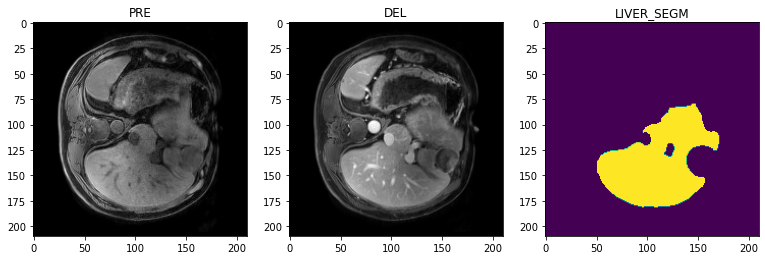

In [42]:
check_ds = monai.data.Dataset(data=external_test_data_dict[:1], transform=test_transforms)


check_loader = DataLoader(check_ds, batch_size=10, num_workers=0, collate_fn=pad_list_data_collate) #collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data['PRE'].shape)
print(check_data['PRE'].shape)
print(check_data['DEL'].shape)
print(check_data['DEL'].shape)


num_display = 10
if check_data['PRE'].shape[0] < num_display:
    num_display = check_data['PRE'].shape[0]

for i in range(num_display):
    acc_id, PRE, DEL , liver_label = (check_data['ACCESSION_ID'][i],check_data['PRE'][i][0],check_data['DEL'][i][0], check_data['SEGM'][i][0])
    print(acc_id)
    
    print('PRE shape: {}, label shape: {}'.format(PRE.shape, liver_label.shape))
    print('PRE mean: {}'.format(np.mean(PRE.numpy())))
    
    
    print('DEL shape: {}, label shape: {}'.format(DEL.shape, liver_label.shape))
    print('DEL mean: {}'.format(np.mean(DEL.numpy())))
    


    slice_num = PRE.shape[2]//2
    
    plt.figure('check', (13, 15))

   
    plt.subplot(1, 3, 1)
    plt.title('PRE')
    plt.imshow(PRE[:,:,slice_num], cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title('DEL')
    plt.imshow(DEL[:,:,slice_num], cmap='gray')
    

    plt.subplot(1, 3, 3)
    plt.title('LIVER_SEGM')
    plt.imshow(liver_label[:,:,slice_num])
    plt.show()


    


0it [00:00, ?it/s]

torch.Size([2, 210, 210, 100])
torch.Size([1, 210, 210, 100])
torch.Size([1, 2, 210, 210, 100])
0.9449106454849243
5.385164807134504
1.8823626425143087
torch.Size([2, 210, 210, 100])
torch.Size([1, 210, 210, 100])
torch.Size([1, 2, 210, 210, 100])
0.9452866315841675
3.7416573867739413
1.1712248801180212
torch.Size([1, 2, 210, 210, 100])
torch.Size([1, 210, 210, 100])


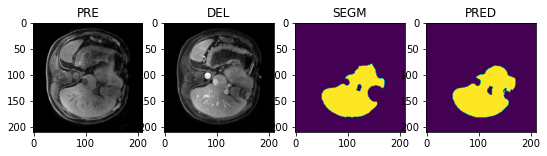

torch.Size([2, 230, 230, 125])
torch.Size([1, 230, 230, 125])
torch.Size([1, 2, 230, 230, 125])
0.957457959651947
7.615773105863909
1.2399492618478507
torch.Size([2, 230, 230, 125])
torch.Size([1, 230, 230, 125])
torch.Size([1, 2, 230, 230, 125])
0.958019495010376
7.615773105863909
0.6178201147229768
torch.Size([1, 2, 230, 230, 125])
torch.Size([1, 230, 230, 125])


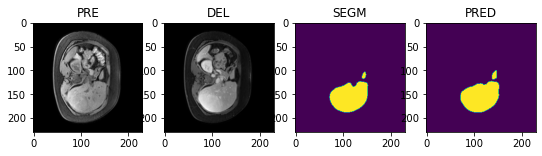

torch.Size([2, 228, 228, 105])
torch.Size([1, 228, 228, 105])
torch.Size([1, 2, 228, 228, 105])
0.9418886303901672
2.449489742783178
1.620061318036238
torch.Size([2, 228, 228, 105])
torch.Size([1, 228, 228, 105])
torch.Size([1, 2, 228, 228, 105])
0.9433706402778625
2.449489742783178
1.0840260969325473
torch.Size([1, 2, 228, 228, 105])
torch.Size([1, 228, 228, 105])


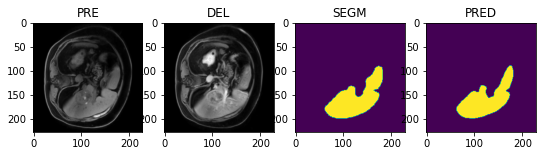

torch.Size([2, 211, 211, 104])
torch.Size([1, 211, 211, 104])
torch.Size([1, 2, 211, 211, 104])
0.6392355561256409
68.84039511798287
22.345279477424963
torch.Size([2, 211, 211, 104])
torch.Size([1, 211, 211, 104])
torch.Size([1, 2, 211, 211, 104])
0.6606202721595764
68.4470598345904
18.717947245299367
torch.Size([1, 2, 211, 211, 104])
torch.Size([1, 211, 211, 104])


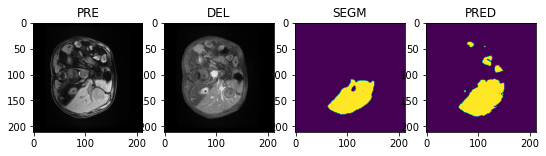

torch.Size([2, 191, 167, 118])
torch.Size([1, 191, 167, 118])
torch.Size([1, 2, 191, 167, 118])
0.8601366281509399
79.39741758265893
28.128591696358736
torch.Size([2, 191, 167, 118])
torch.Size([1, 191, 167, 118])
torch.Size([1, 2, 191, 167, 118])
0.9076354503631592
6.0
1.51900379284397
torch.Size([1, 2, 191, 167, 118])
torch.Size([1, 191, 167, 118])


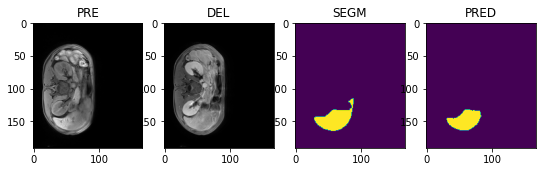

torch.Size([2, 211, 211, 109])
torch.Size([1, 211, 211, 109])
torch.Size([1, 2, 211, 211, 109])
0.9204484224319458
90.59773693439178
9.59930390536457
torch.Size([2, 211, 211, 109])
torch.Size([1, 211, 211, 109])
torch.Size([1, 2, 211, 211, 109])
0.9339801073074341
6.164414002968976
1.222071304472416
torch.Size([1, 2, 211, 211, 109])
torch.Size([1, 211, 211, 109])


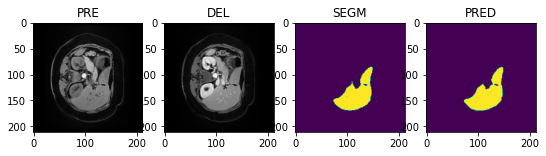

torch.Size([2, 201, 178, 108])
torch.Size([1, 201, 178, 108])
torch.Size([1, 2, 201, 178, 108])
0.962252676486969
2.8284271247461903
1.7212436732565937
torch.Size([2, 201, 178, 108])
torch.Size([1, 201, 178, 108])
torch.Size([1, 2, 201, 178, 108])
0.9638784527778625
2.8284271247461903
0.559965890110267
torch.Size([1, 2, 201, 178, 108])
torch.Size([1, 201, 178, 108])


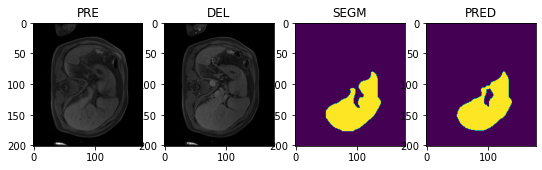

torch.Size([2, 204, 204, 100])
torch.Size([1, 204, 204, 100])
torch.Size([1, 2, 204, 204, 100])
0.944023609161377
4.358898943540674
2.153507029185561
torch.Size([2, 204, 204, 100])
torch.Size([1, 204, 204, 100])
torch.Size([1, 2, 204, 204, 100])
0.9488166570663452
2.8284271247461903
0.9008847344354552
torch.Size([1, 2, 204, 204, 100])
torch.Size([1, 204, 204, 100])


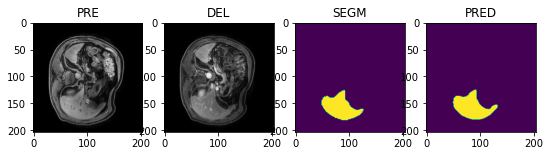

torch.Size([2, 189, 189, 105])
torch.Size([1, 189, 189, 105])
torch.Size([1, 2, 189, 189, 105])
0.8359005451202393
7.810249675906654
3.0096701015400917
torch.Size([2, 189, 189, 105])
torch.Size([1, 189, 189, 105])
torch.Size([1, 2, 189, 189, 105])
0.8368247151374817
7.615773105863909
2.459246863612451
torch.Size([1, 2, 189, 189, 105])
torch.Size([1, 189, 189, 105])


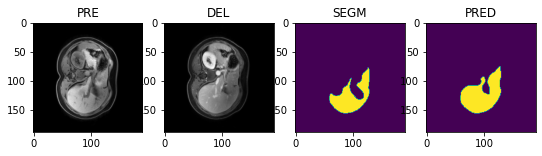

torch.Size([2, 201, 201, 96])
torch.Size([1, 201, 201, 96])
torch.Size([1, 2, 201, 201, 96])
0.9712338447570801
1.4142135623730951
2.653436100977739
torch.Size([2, 201, 201, 96])
torch.Size([1, 201, 201, 96])
torch.Size([1, 2, 201, 201, 96])
0.9724563360214233
1.4142135623730951
0.4768278159394323
torch.Size([1, 2, 201, 201, 96])
torch.Size([1, 201, 201, 96])


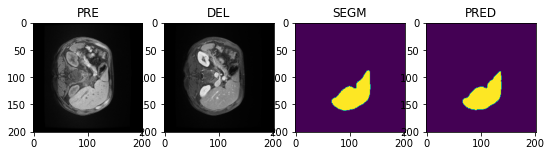

torch.Size([2, 210, 210, 100])
torch.Size([1, 210, 210, 100])
torch.Size([1, 2, 210, 210, 100])
0.9696533679962158
2.23606797749979
2.010446490485859
torch.Size([2, 210, 210, 100])
torch.Size([1, 210, 210, 100])
torch.Size([1, 2, 210, 210, 100])
0.9704200625419617
1.7320508075688772
0.5610740035454682
torch.Size([1, 2, 210, 210, 100])
torch.Size([1, 210, 210, 100])


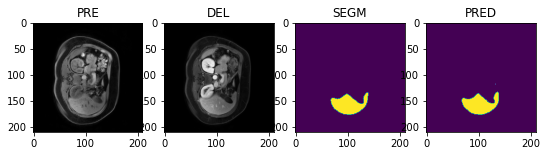

torch.Size([2, 210, 210, 110])
torch.Size([1, 210, 210, 110])
torch.Size([1, 2, 210, 210, 110])
0.9652197360992432
100.56738530478496
11.236812274224347
torch.Size([2, 210, 210, 110])
torch.Size([1, 210, 210, 110])
torch.Size([1, 2, 210, 210, 110])
0.9730176329612732
1.4142135623730951
0.5155509358189383
torch.Size([1, 2, 210, 210, 110])
torch.Size([1, 210, 210, 110])


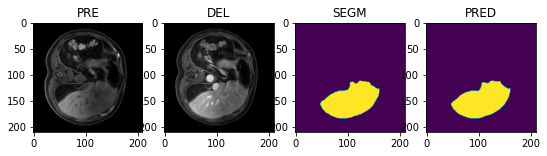

torch.Size([2, 210, 210, 125])
torch.Size([1, 210, 210, 125])
torch.Size([1, 2, 210, 210, 125])
0.9126144647598267
13.076696830622021
2.3900814434872952
torch.Size([2, 210, 210, 125])
torch.Size([1, 210, 210, 125])
torch.Size([1, 2, 210, 210, 125])
0.9126144647598267
13.076696830622021
2.3900814434872952
torch.Size([1, 2, 210, 210, 125])
torch.Size([1, 210, 210, 125])


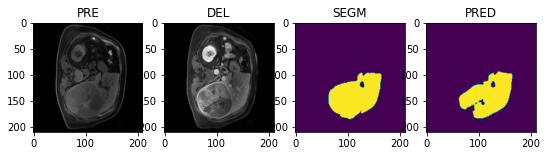

torch.Size([2, 172, 172, 100])
torch.Size([1, 172, 172, 100])
torch.Size([1, 2, 172, 172, 100])
0.9348887205123901
26.720778431774775
3.2409486066774167
torch.Size([2, 172, 172, 100])
torch.Size([1, 172, 172, 100])
torch.Size([1, 2, 172, 172, 100])
0.9457221627235413
5.0990195135927845
1.205561333376349
torch.Size([1, 2, 172, 172, 100])
torch.Size([1, 172, 172, 100])


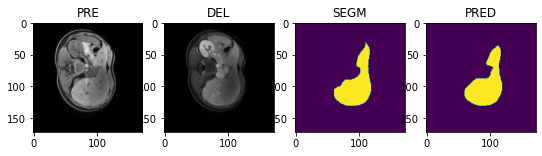

torch.Size([2, 221, 221, 114])
torch.Size([1, 221, 221, 114])
torch.Size([1, 2, 221, 221, 114])
0.8261232376098633
85.01470445787137
35.28524999341319
torch.Size([2, 221, 221, 114])
torch.Size([1, 221, 221, 114])
torch.Size([1, 2, 221, 221, 114])
0.9634968042373657
2.8284271247461903
0.8542583538466026
torch.Size([1, 2, 221, 221, 114])
torch.Size([1, 221, 221, 114])


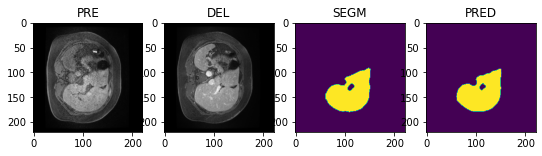

torch.Size([2, 207, 207, 105])
torch.Size([1, 207, 207, 105])
torch.Size([1, 2, 207, 207, 105])
0.9448058605194092
40.024992192379
3.904118238101532
torch.Size([2, 207, 207, 105])
torch.Size([1, 207, 207, 105])
torch.Size([1, 2, 207, 207, 105])
0.9570015668869019
2.449489742783178
0.8403528519103393
torch.Size([1, 2, 207, 207, 105])
torch.Size([1, 207, 207, 105])


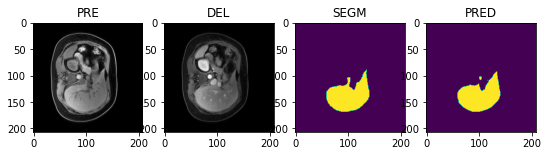

[0.9449106454849243, 0.957457959651947, 0.9418886303901672, 0.6392355561256409, 0.8601366281509399, 0.9204484224319458, 0.962252676486969, 0.944023609161377, 0.8359005451202393, 0.9712338447570801, 0.9696533679962158, 0.9652197360992432, 0.9126144647598267, 0.9348887205123901, 0.8261232376098633, 0.9448058605194092]


DICE  POST_DICE        HD95  POST_HD95  InferenceTime
count  16.000000  16.000000   16.000000  16.000000      16.000000
mean    0.908175   0.924573   33.646149   8.481571       0.005431
std     0.085226   0.078179   37.553681  16.284977       0.001712
min     0.639236   0.660620    1.414214   1.414214       0.003244
25%     0.899495   0.928639    3.976281   2.449490       0.004078
50%     0.942956   0.947269   10.443473   3.285042       0.005258
75%     0.958657   0.963592   71.479651   6.527254       0.006610
max     0.971234   0.973018  100.567385  68.447060       0.008540

In [43]:
roi_size = (224, 224, 128)

df_external_test_results = run_inference_and_evaluate(
        model=model, 
        data_loader= external_test_loader, 
        roi_size=roi_size, 
        plot_images=True, 
        save_output=False) #, max_eval = 2

torch.cuda.empty_cache()
df_external_test_results['EXPERIMENT_ID'] = 'PARIS-PRE-DEL'
df_external_test_results.describe()

In [44]:
df_external_test_results.to_csv('../ExternalTestingResults/Paris-PRE-DEL.csv')